## Libraries

In [59]:
!pip install kagglehub

In [60]:
import os
import PIL
import cv2
import uuid
import shutil
import random
import glob as gb
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from tqdm import tqdm
from scipy.special import gamma

from keras.optimizers import *
from keras.regularizers import l1_l2
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import LearningRateScheduler
from keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.python.keras.utils import tf_utils

from tensorflow.keras.metrics import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import tensorflow_addons as tfa


## Dataset download


In [61]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("awsaf49/cbis-ddsm-breast-cancer-image-dataset")
print("Path to dataset files:", path)

# List files in downloaded path
print(os.listdir(path))


Path to dataset files: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset
['jpeg', 'csv']


In [62]:
import os

def print_tree(start_path, indent=''):
    items = sorted(os.listdir(start_path))
    for item in items[:-1]:
        path = os.path.join(start_path, item)
        print(indent + '|-- ' + item)
        if os.path.isdir(path):
            print_tree(path, indent + '    ')

# Print the tree
print("Directory Tree:\n")
print_tree(path)


Directory Tree:

|-- csv
    |-- calc_case_description_test_set.csv
    |-- calc_case_description_train_set.csv
    |-- dicom_info.csv
    |-- mass_case_description_test_set.csv
    |-- mass_case_description_train_set.csv


### Loading the dataset


In [63]:
import pandas as pd

csv_path = os.path.join(path, 'csv')

calc_train = pd.read_csv(os.path.join(csv_path, 'calc_case_description_train_set.csv'))
calc_test = pd.read_csv(os.path.join(csv_path, 'calc_case_description_test_set.csv'))
mass_train = pd.read_csv(os.path.join(csv_path, 'mass_case_description_train_set.csv'))
mass_test = pd.read_csv(os.path.join(csv_path, 'mass_case_description_test_set.csv'))
dicom_df = pd.read_csv(os.path.join(csv_path, 'dicom_info.csv'))

In [64]:
# Increase maximum column width
pd.set_option('display.max_colwidth', None)

mass_train[['image file path', 'cropped image file path', 'ROI mask file path']].head()

image file path  \
0    Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.422112722213189649807611434612228974994/1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515/000000.dcm   
1   Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.319478999311971442426185353560182990988/1.3.6.1.4.1.9590.100.1.2.359308329312397897125630708681441180834/000000.dcm   
2     Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.347107867812656628709864319310977895697/1.3.6.1.4.1.9590.100.1.2.89180046211022531834352631483669346540/000000.dcm   
3   Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.272600286511817402806912403581910920939/1.3.6.1.4.1.9590.100.1.2.295360926313492745441868049270168300162/000000.dcm   
4  Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.174047308712169195014610267031196524486/1.3.6.1.4.1.9590.100.1.2.410524754913057908920631336070876889890/000000.dcm   

                                                                                                                                                         cropped image file path  \
0   Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.108268213011361124203859148071588939106/1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650/000000.dcm   
1  Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.188473874511440575807446266233629582526/1.3.6.1.4.1.9590.100.1.2.227955274711225756835838775062793186053/000000.dcm   
2   Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.414182170112396175925115449620455230167/1.3.6.1.4.1.9590.100.1.2.429120414011832984817094399141838850375/000000.dcm   
3  Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.342549219112801262604988012930063078769/1.3.6.1.4.1.9590.100.1.2.115134232113001553100559896703407510515/000000.dcm   
4  Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.341142631111685501338932932302380583774/1.3.6.1.4.1.9590.100.1.2.12857366312625701203276284233604184846/000000.dcm   

                                                                                                                                                                ROI mask file path  
0   Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.108268213011361124203859148071588939106/1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650/000001.dcm\n  
1  Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.188473874511440575807446266233629582526/1.3.6.1.4.1.9590.100.1.2.227955274711225756835838775062793186053/000001.dcm\n  
2   Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.414182170112396175925115449620455230167/1.3.6.1.4.1.9590.100.1.2.429120414011832984817094399141838850375/000001.dcm\n  
3  Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.342549219112801262604988012930063078769/1.3.6.1.4.1.9590.100.1.2.115134232113001553100559896703407510515/000001.dcm\n  
4  Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.341142631111685501338932932302380583774/1.3.6.1.4.1.9590.100.1.2.12857366312625701203276284233604184846/000001.dcm\n

In [65]:
dicom_df.head()

file_path  \
0  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.dcm   
1  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.dcm   
2  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.267213171011171858918434139331210917771/1-032.dcm   
3  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.381187369611524586537789902641525311317/1-052.dcm   
4  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.381187369611524586537789902641525311317/2-204.dcm   

                                                                                  image_path  \
0  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg   
1  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg   
2  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213171011171858918434139331210917771/1-032.jpg   
3  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187369611524586537789902641525311317/1-052.jpg   
4  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187369611524586537789902641525311317/2-204.jpg   

   AccessionNumber  BitsAllocated  BitsStored BodyPartExamined  Columns  \
0              NaN             16          16           BREAST      351   
1              NaN             16          16           BREAST     3526   
2              NaN             16          16           BREAST     1546   
3              NaN             16          16           BREAST       97   
4              NaN              8           8      Left Breast     3104   

   ContentDate  ContentTime ConversionType  ...  \
0     20160426   131732.685            WSD  ...   
1     20160426   143829.101            WSD  ...   
2     20160503   111956.298            WSD  ...   
3     20160503   115347.770            WSD  ...   
4     20160503   115347.770            WSD  ...   

   SecondaryCaptureDeviceManufacturerModelName      SeriesDescription  \
0                                       MATLAB         cropped images   
1                                       MATLAB  full mammogram images   
2                                       MATLAB  full mammogram images   
3                                       MATLAB         cropped images   
4                                       MATLAB                    NaN   

                                                  SeriesInstanceUID  \
0  1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304   
1  1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849   
2  1.3.6.1.4.1.9590.100.1.2.267213171011171858918434139331210917771   
3  1.3.6.1.4.1.9590.100.1.2.381187369611524586537789902641525311317   
4  1.3.6.1.4.1.9590.100.1.2.381187369611524586537789902641525311317   

  SeriesNumber SmallestImagePixelValue  SpecificCharacterSet   StudyDate  \
0            1                   23078            ISO_IR 100  20160720.0   
1            1                       0            ISO_IR 100  20160720.0   
2            1                       0            ISO_IR 100  20160807.0   
3            1                   32298            ISO_IR 100  20170829.0   
4            1                       0            ISO_IR 100         NaN   

  StudyID                                                  StudyInstanceUID  \
0    DDSM  1.3.6.1.4.1.9590.100.1.2.271867287611061855725036643043149877819   
1    DDSM  1.3.6.1.4.1.9590.100.1.2.161516517311681906612443997862211969669   
2    DDSM  1.3.6.1.4.1.9590.100.1.2.291043622711253836701017460903623585574   
3    DDSM  1.3.6.1.4.1.9590.100.1.2.335006093711888937440665960211609580159   
4    DDSM  1.3.6.1.4.1.9590.100.1.2.335006093711888937440665960211609580159   

   StudyTime  
0   214951.0  
1   193426.0  
2   161814.0  
3   180109.0  
4        NaN  

[5 rows x 38 columns]

In [66]:
# correct_dir = path

# csv_path = os.path.join(correct_dir, 'csv')
# dicom_df = pd.read_csv(os.path.join(csv_path, "dicom_info.csv"))

cropped_images = dicom_df[dicom_df.SeriesDescription=="cropped images"].image_path
full_mammogram = dicom_df[dicom_df.SeriesDescription=="full mammogram images"].image_path
roi_mask = dicom_df[dicom_df.SeriesDescription=="ROI mask images"].image_path

print(f"Number of cropped images: {len(cropped_images)}")
print(f"Number of full mammogram images: {len(full_mammogram)}")
print(f"Number of ROI mask images: {len(roi_mask)}")

Number of cropped images: 3567
Number of full mammogram images: 2857
Number of ROI mask images: 3247


## Data Cleaning


### Correcting the path of images

In [67]:
def replace_path(sample, old_path, new_path):
    return sample.replace(old_path, new_path, regex=True)

print("Path of cropped images before path is replaced:")
print(cropped_images.iloc[0])
correct_dir = os.path.join(path, 'jpeg')
cropped_images = replace_path(cropped_images, "CBIS-DDSM/jpeg", correct_dir)
print('\nCropped Images new paths:')
print(cropped_images.iloc[0])

Path of cropped images before path is replaced:
CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg

Cropped Images new paths:
/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg


In [68]:
print("Path of full mammogram before path is replaced:")
print(full_mammogram.iloc[0])
correct_dir = os.path.join(path, 'jpeg')
full_mammogram = replace_path(full_mammogram, "CBIS-DDSM/jpeg", correct_dir)
print('\nFull mammogram new paths:')
print(full_mammogram.iloc[0])

Path of full mammogram before path is replaced:
CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg

Full mammogram new paths:
/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg


In [69]:
print("Path of ROI mask before path is replaced:")
print(roi_mask.iloc[0])
correct_dir = os.path.join(path, 'jpeg')
roi_mask = replace_path(roi_mask, "CBIS-DDSM/jpeg", correct_dir)
print('\nROI mask new paths:')
print(roi_mask.iloc[0])

Path of ROI mask before path is replaced:
CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg

ROI mask new paths:
/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg


### Plotting the sample images

Cropped Images:


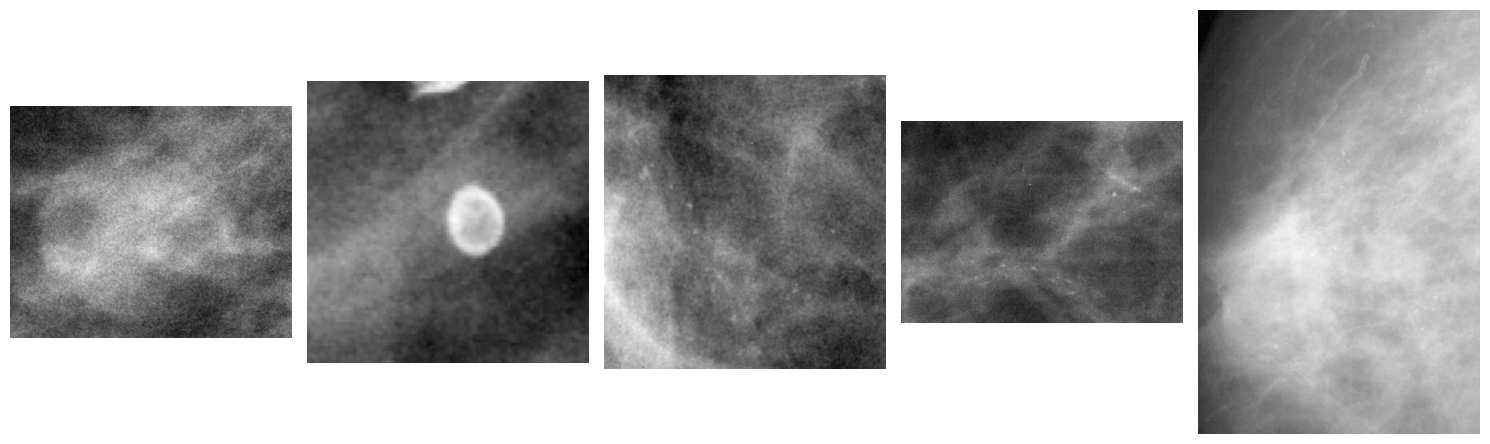

Full Mammogram Images:


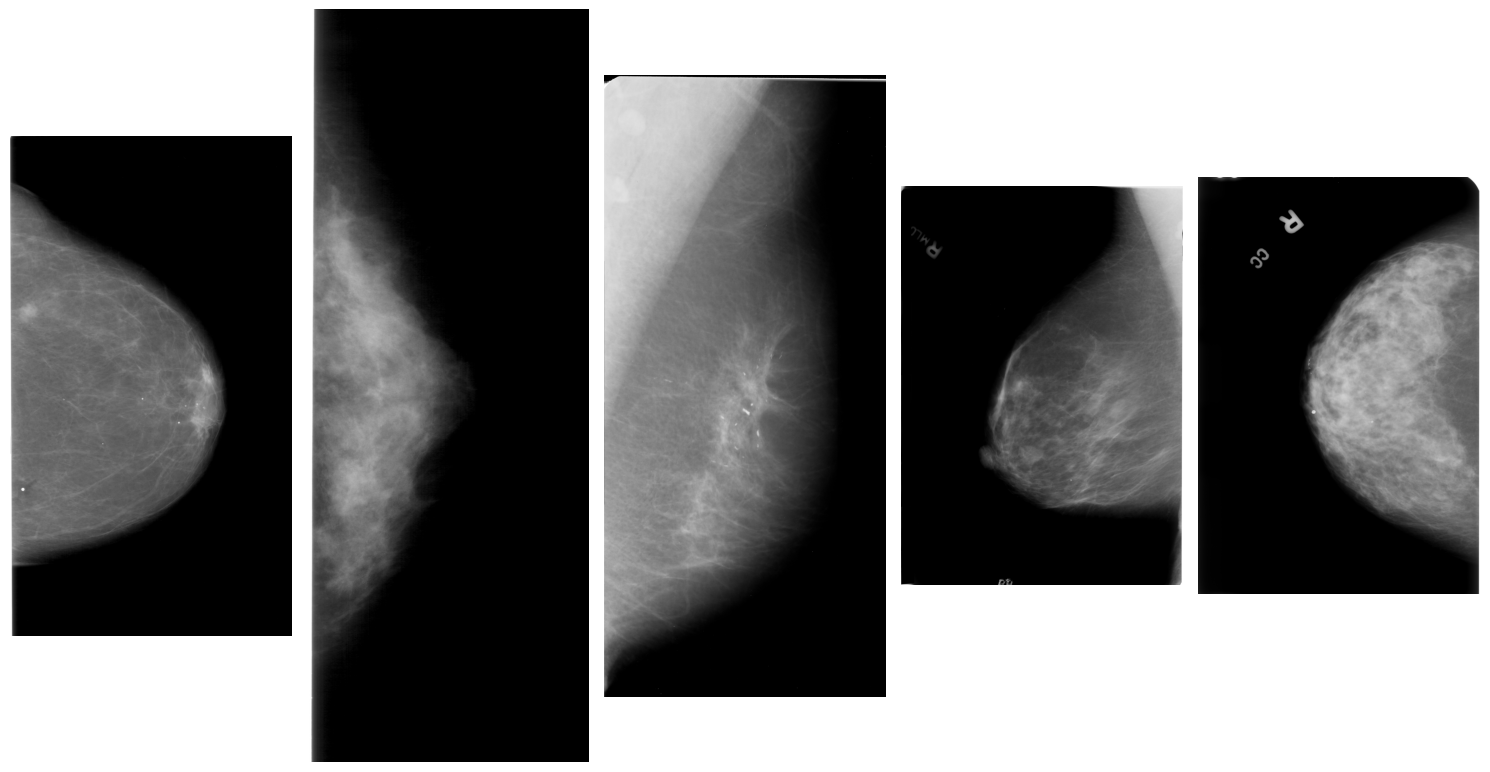

ROI Mask Images:


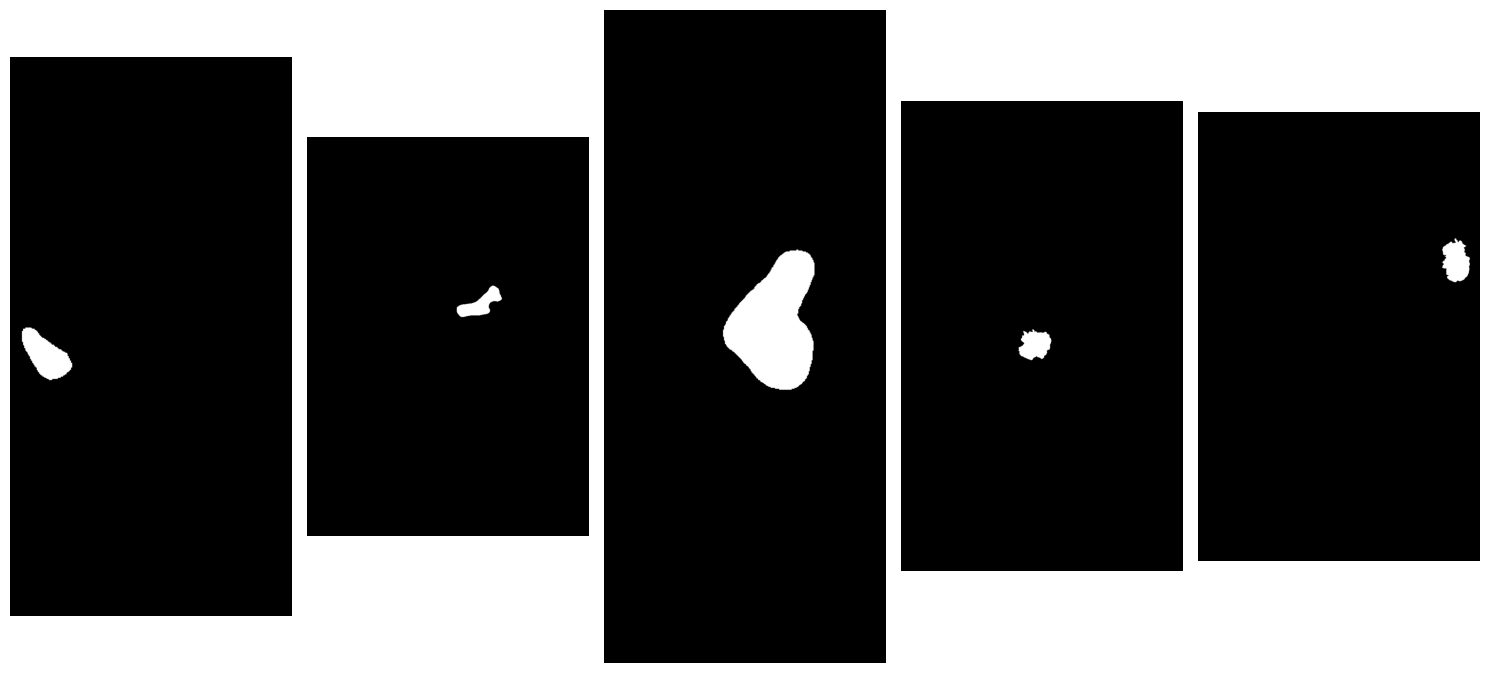

In [70]:
# Plot function
def plot_samples(sample, row=15, col=15):
    plt.figure(figsize=(row, col))
    for i, file in enumerate(sample[:5]):
        try:
            img = PIL.Image.open(file).convert("L")
            plt.subplot(1, 5, i + 1)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
        except Exception as e:
            print(f"Error loading image {file}: {e}")
    plt.tight_layout()
    plt.show()

# Display cropped images
print("Cropped Images:")
plot_samples(cropped_images)

print("Full Mammogram Images:")
plot_samples(full_mammogram)

print("ROI Mask Images:")
plot_samples(roi_mask)

In [71]:

def get_image_file_name(data, new_dict):
    for dicom in data:
        relative_path = dicom.split("jpeg/")[-1]
        new_dict[relative_path] = dicom
    print(f"Stored {len(new_dict)} image paths.")


cropped_images_dict = dict()
full_mammo_dict = dict()
roi_img_dict = dict()

get_image_file_name(cropped_images, cropped_images_dict)
get_image_file_name(full_mammogram, full_mammo_dict)
get_image_file_name(roi_mask, roi_img_dict)



Stored 3567 image paths.
Stored 2857 image paths.
Stored 3247 image paths.


### Fixing image path from dicom paths to correct image paths

In [72]:
def fix_image_path(data):
    """Correct dicom paths to correct image paths."""
    for indx, image in enumerate(data.values):

        img_name = image[11].split('/')[2]
        # Find matching key in full_mammo_dict
        matches = [k for k in full_mammo_dict.keys() if k.startswith(img_name + '/')]
        if matches:
            # Use the matched key if found
            data.iloc[indx, 11] = full_mammo_dict[matches[0]]
        else:
            data.iloc[indx, 11] = None

        img_name = image[12].split('/')[2]
        matches = [k for k in cropped_images_dict.keys() if k.startswith(img_name + '/')]
        if matches:
            data.iloc[indx, 12] = cropped_images_dict[matches[0]] # Use the matched key if found
        else:
            data.iloc[indx, 12] = None

        img_name = image[13].split('/')[2]
        matches = [k for k in roi_img_dict.keys() if k.startswith(img_name + '/')]
        if matches:
            data.iloc[indx, 13] = roi_img_dict[matches[0]] # Use the matched key if found
        else:
            data.iloc[indx, 13] = None

In [73]:
mass_train.head(5)

patient_id  breast_density left or right breast image view  abnormality id  \
0    P_00001               3                 LEFT         CC               1   
1    P_00001               3                 LEFT        MLO               1   
2    P_00004               3                 LEFT         CC               1   
3    P_00004               3                 LEFT        MLO               1   
4    P_00004               3                RIGHT        MLO               1   

  abnormality type                          mass shape   mass margins  \
0             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
1             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
2             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
3             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
4             mass                                OVAL  CIRCUMSCRIBED   

   assessment  pathology  subtlety  \
0           4  MALIGNANT         4   
1           4  MALIGNANT         4   
2           4     BENIGN         3   
3           4     BENIGN         3   
4           4     BENIGN         5   

                                                                                                                                                                image file path  \
0    Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.422112722213189649807611434612228974994/1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515/000000.dcm   
1   Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.319478999311971442426185353560182990988/1.3.6.1.4.1.9590.100.1.2.359308329312397897125630708681441180834/000000.dcm   
2     Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.347107867812656628709864319310977895697/1.3.6.1.4.1.9590.100.1.2.89180046211022531834352631483669346540/000000.dcm   
3   Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.272600286511817402806912403581910920939/1.3.6.1.4.1.9590.100.1.2.295360926313492745441868049270168300162/000000.dcm   
4  Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.174047308712169195014610267031196524486/1.3.6.1.4.1.9590.100.1.2.410524754913057908920631336070876889890/000000.dcm   

                                                                                                                                                         cropped image file path  \
0   Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.108268213011361124203859148071588939106/1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650/000000.dcm   
1  Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.188473874511440575807446266233629582526/1.3.6.1.4.1.9590.100.1.2.227955274711225756835838775062793186053/000000.dcm   
2   Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.414182170112396175925115449620455230167/1.3.6.1.4.1.9590.100.1.2.429120414011832984817094399141838850375/000000.dcm   
3  Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.342549219112801262604988012930063078769/1.3.6.1.4.1.9590.100.1.2.115134232113001553100559896703407510515/000000.dcm   
4  Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.341142631111685501338932932302380583774/1.3.6.1.4.1.9590.100.1.2.12857366312625701203276284233604184846/000000.dcm   

                                                                                                                                                                ROI mask file path  
0   Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.108268213011361124203859148071588939106/1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650/000001.dcm\n  
1  Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.188473874511440575807446266233629582526/1.3.6.1.4.1.9590.100.1.2.227955274711225756835838775062793186053/000001.dcm\n  
2   Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.414182170112396175925115449620455230167/1.3.6.1.4.1.9590.100.1.2.4291204140118329848170943991

In [74]:
fix_image_path(mass_train)

In [75]:
mass_train = mass_train.rename(columns={'left or right breast': 'left_or_right_breast',
                                        'image view': 'image_view',
                                        'abnormality id': 'abnormality_id',
                                        'abnormality type': 'abnormality_type',
                                        'mass shape': 'mass_shape',
                                        'mass margins': 'mass_margins',
                                        'image file path': 'image_file_path',
                                        'cropped image file path': 'cropped_image_file_path',
                                        'ROI mask file path': 'ROI_mask_file_path'})
mass_train.head(5)

patient_id  breast_density left_or_right_breast image_view  abnormality_id  \
0    P_00001               3                 LEFT         CC               1   
1    P_00001               3                 LEFT        MLO               1   
2    P_00004               3                 LEFT         CC               1   
3    P_00004               3                 LEFT        MLO               1   
4    P_00004               3                RIGHT        MLO               1   

  abnormality_type                          mass_shape   mass_margins  \
0             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
1             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
2             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
3             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
4             mass                                OVAL  CIRCUMSCRIBED   

   assessment  pathology  subtlety  \
0           4  MALIGNANT         4   
1           4  MALIGNANT         4   
2           4     BENIGN         3   
3           4     BENIGN         3   
4           4     BENIGN         5   

                                                                                                                       image_file_path  \
0  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515/1-211.jpg   
1  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.359308329312397897125630708681441180834/1-207.jpg   
2   /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.89180046211022531834352631483669346540/1-250.jpg   
3  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.295360926313492745441868049270168300162/1-067.jpg   
4  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.410524754913057908920631336070876889890/1-056.jpg   

                                                                                                               cropped_image_file_path  \
0  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650/2-249.jpg   
1  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.227955274711225756835838775062793186053/1-289.jpg   
2  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.429120414011832984817094399141838850375/2-295.jpg   
3  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.115134232113001553100559896703407510515/2-244.jpg   
4   /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.12857366312625701203276284233604184846/1-182.jpg   

                                                                                                                    ROI_mask_file_path  
0  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650/1-250.jpg  
1  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.227955274711225756835838775062793186053/2-288.jpg  
2  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.429120414011832984817094399141838850375/1-296.jpg  
3  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.115134232113001553100559896703407510515/1-245.jpg  
4   /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.12857366312625701203276284233604184846/2-183.jpg

In [76]:
fix_image_path(mass_test)

In [77]:
mass_test = mass_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                        'image view': 'image_view',
                                        'abnormality id': 'abnormality_id',
                                        'abnormality type': 'abnormality_type',
                                        'mass shape': 'mass_shape',
                                        'mass margins': 'mass_margins',
                                        'image file path': 'image_file_path',
                                        'cropped image file path': 'cropped_image_file_path',
                                        'ROI mask file path': 'ROI_mask_file_path'})
mass_test.head(5)

patient_id  breast_density left_or_right_breast image_view  abnormality_id  \
0    P_00016               4                 LEFT         CC               1   
1    P_00016               4                 LEFT        MLO               1   
2    P_00017               2                 LEFT         CC               1   
3    P_00017               2                 LEFT        MLO               1   
4    P_00032               3                RIGHT         CC               1   

  abnormality_type mass_shape   mass_margins  assessment  pathology  subtlety  \
0             mass  IRREGULAR     SPICULATED           5  MALIGNANT         5   
1             mass  IRREGULAR     SPICULATED           5  MALIGNANT         5   
2             mass      ROUND  CIRCUMSCRIBED           4  MALIGNANT         4   
3             mass      ROUND    ILL_DEFINED           4  MALIGNANT         4   
4             mass      ROUND       OBSCURED           0     BENIGN         2   

                                                                                                                       image_file_path  \
0  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.245063149211255120613007755642780114172/1-271.jpg   
1   /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.85952214611170506017891429690540035518/1-100.jpg   
2   /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.22131189612893294827907969600765582967/1-101.jpg   
3  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.239949064412092068706566726490415129934/1-102.jpg   
4  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.215081818713600536113960661873725083371/1-103.jpg   

                                                                                                               cropped_image_file_path  \
0   /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.30820586311062570442302321942433426184/2-272.jpg   
1  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.381440141511137044327302306604206077287/2-273.jpg   
2  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.212143028513012144941507232513982203672/1-274.jpg   
3   /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.15403043813402510742192372832381918984/1-275.jpg   
4  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.199593071810497070809647901570077988031/1-276.jpg   

                                                                                                                    ROI_mask_file_path  
0   /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.30820586311062570442302321942433426184/1-083.jpg  
1  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.381440141511137044327302306604206077287/1-084.jpg  
2  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.212143028513012144941507232513982203672/2-085.jpg  
3   /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.15403043813402510742192372832381918984/2-086.jpg  
4  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.199593071810497070809647901570077988031/2-087.jpg

In [78]:
fix_image_path(calc_train)

In [79]:
calc_train = calc_train.rename(columns={'left or right breast': 'left_or_right_breast',
                                        'image view': 'image_view',
                                        'abnormality id': 'abnormality_id',
                                        'abnormality type': 'abnormality_type',
                                        'calc type': 'calc_type',
                                        'breast density': 'breast_density',
                                        'calc distribution': 'calc_distribution',
                                        'image file path': 'image_file_path',
                                        'cropped image file path': 'cropped_image_file_path',
                                        'ROI mask file path': 'ROI_mask_file_path'})
calc_train.head()


patient_id  breast_density left_or_right_breast image_view  abnormality_id  \
0    P_00005               3                RIGHT         CC               1   
1    P_00005               3                RIGHT        MLO               1   
2    P_00007               4                 LEFT         CC               1   
3    P_00007               4                 LEFT        MLO               1   
4    P_00008               1                 LEFT         CC               1   

  abnormality_type    calc_type calc_distribution  assessment  \
0    calcification    AMORPHOUS         CLUSTERED           3   
1    calcification    AMORPHOUS         CLUSTERED           3   
2    calcification  PLEOMORPHIC            LINEAR           4   
3    calcification  PLEOMORPHIC            LINEAR           4   
4    calcification          NaN          REGIONAL           2   

                 pathology  subtlety  \
0                MALIGNANT         3   
1                MALIGNANT         3   
2                   BENIGN         4   
3                   BENIGN         4   
4  BENIGN_WITHOUT_CALLBACK         3   

                                                                                                                       image_file_path  \
0   /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.47414316010368386519740343172775938548/1-188.jpg   
1  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.250596608311207922527805669693579696727/1-189.jpg   
2  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.228699627313487111012474405462022068297/1-190.jpg   
3  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.104743410411133110629448544090466900446/1-191.jpg   
4  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.406725628213826290127343763811145520834/1-192.jpg   

                                                                                                               cropped_image_file_path  \
0  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.393344010211719049419601138200355094682/2-191.jpg   
1  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.296281207812130400303493285473798422894/1-192.jpg   
2  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.314135871111943890422150247820137952041/1-193.jpg   
3   /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.91458279612485515203413781822560852485/1-194.jpg   
4  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.281397494612871934937455783843630775495/1-195.jpg   

                                                                                                                    ROI_mask_file_path  
0  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.393344010211719049419601138200355094682/1-107.jpg  
1  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.296281207812130400303493285473798422894/2-108.jpg  
2  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.314135871111943890422150247820137952041/2-109.jpg  
3   /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.91458279612485515203413781822560852485/2-110.jpg  
4  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.281397494612871934937455783843630775495/2-111.jpg

In [80]:
fix_image_path(calc_test)

In [81]:
calc_test = calc_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                        'image view': 'image_view',
                                        'abnormality id': 'abnormality_id',
                                        'abnormality type': 'abnormality_type',
                                        'calc type': 'calc_type',
                                        'calc distribution': 'calc_distribution',
                                        'breast density': 'breast_density',
                                        'image file path': 'image_file_path',
                                        'cropped image file path': 'cropped_image_file_path',
                                        'ROI mask file path': 'ROI_mask_file_path'})
calc_test.head()


patient_id  breast_density left_or_right_breast image_view  abnormality_id  \
0    P_00038               2                 LEFT         CC               1   
1    P_00038               2                 LEFT        MLO               1   
2    P_00038               2                RIGHT         CC               1   
3    P_00038               2                RIGHT         CC               2   
4    P_00038               2                RIGHT        MLO               1   

  abnormality_type             calc_type calc_distribution  assessment  \
0    calcification  PUNCTATE-PLEOMORPHIC         CLUSTERED           4   
1    calcification  PUNCTATE-PLEOMORPHIC         CLUSTERED           4   
2    calcification              VASCULAR               NaN           2   
3    calcification              VASCULAR               NaN           2   
4    calcification              VASCULAR               NaN           2   

                 pathology  subtlety image_file_path  \
0                   BENIGN         2            None   
1                   BENIGN         2            None   
2  BENIGN_WITHOUT_CALLBACK         5            None   
3  BENIGN_WITHOUT_CALLBACK         5            None   
4  BENIGN_WITHOUT_CALLBACK         5            None   

                                                                                                               cropped_image_file_path  \
0  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.419081637812053404913157930753972718515/1-245.jpg   
1  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.188613955710170417803011787532523988680/1-246.jpg   
2  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.244876997513875090239564803900035037851/1-248.jpg   
3  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.360550081712464813321995483083632007570/1-247.jpg   
4  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.126295284812046209819441424913058621714/1-249.jpg   

  ROI_mask_file_path  
0               None  
1               None  
2               None  
3               None  
4               None

## Data Visualisation

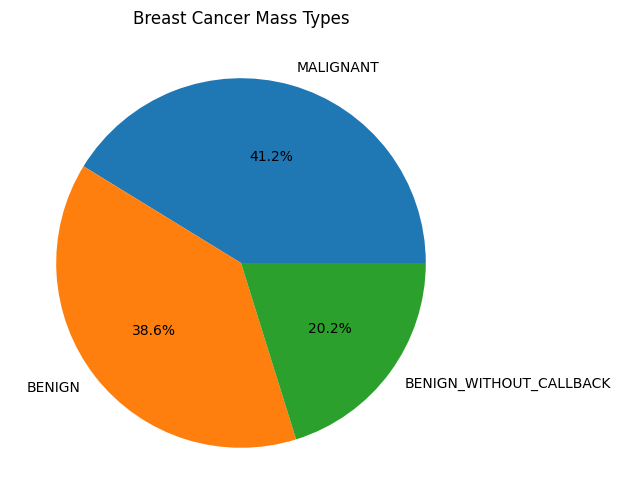

In [82]:
value = mass_train['pathology'].value_counts() + calc_train['pathology'].value_counts()
plt.figure(figsize=(8,6))

plt.pie(value, labels=value.index, autopct='%1.1f%%')
plt.title('Breast Cancer Mass Types', fontsize=12)
plt.show()

<ipython-input-83-d3adcda96fbd>:4: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.countplot(data=mass_train, y='assessment', hue='pathology', palette=mass_palette)


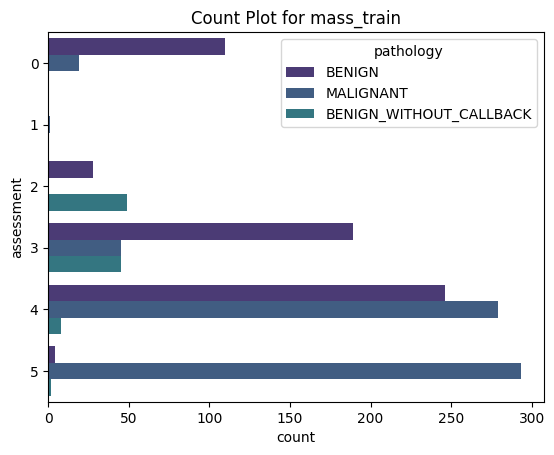

<ipython-input-83-d3adcda96fbd>:10: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.countplot(data=calc_train, y='assessment', hue='pathology', palette=calc_palette)


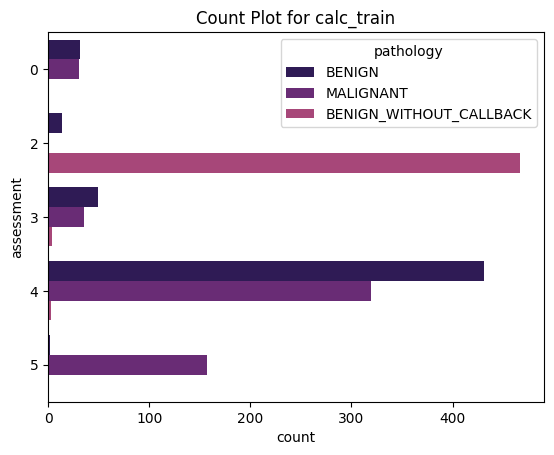

In [83]:
# Set the color palette for mass_train
import seaborn as sns
mass_palette = sns.color_palette("viridis", n_colors=len(mass_train['assessment'].unique()))
sns.countplot(data=mass_train, y='assessment', hue='pathology', palette=mass_palette)
plt.title('Count Plot for mass_train')
plt.show()

# Set the color palette for calc_train
calc_palette = sns.color_palette("magma", n_colors=len(calc_train['assessment'].unique()))
sns.countplot(data=calc_train, y='assessment', hue='pathology', palette=calc_palette)
plt.title('Count Plot for calc_train')
plt.show()

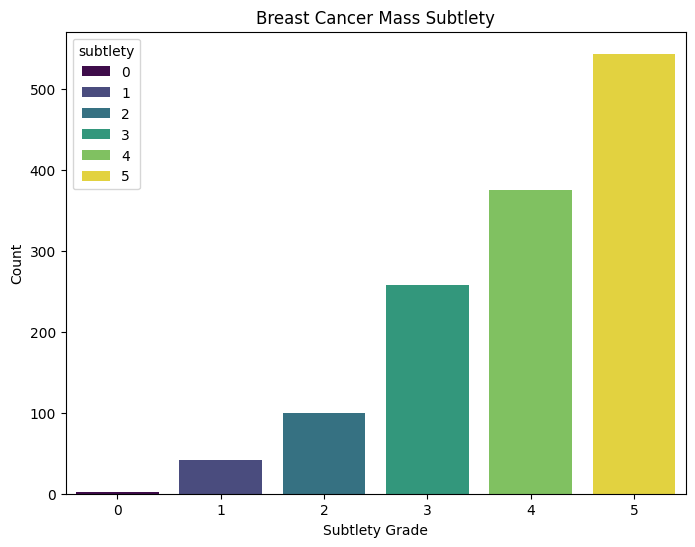

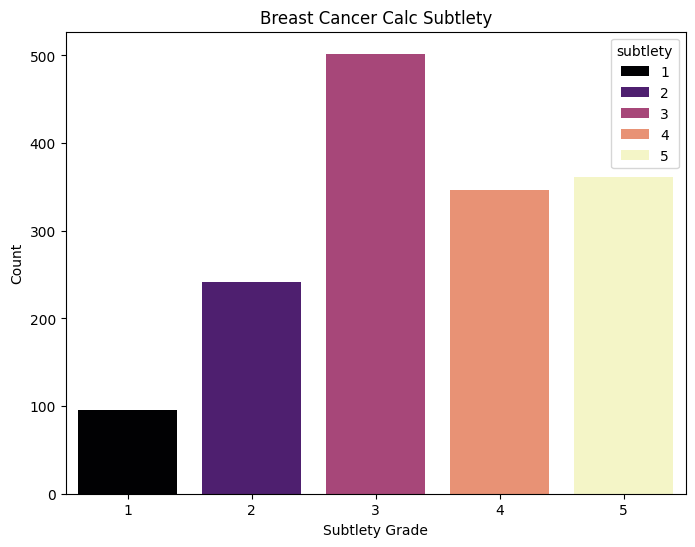

In [84]:
plt.figure(figsize=(8, 6))
sns.countplot(data=mass_train, x='subtlety', palette='viridis', hue='subtlety')
plt.title('Breast Cancer Mass Subtlety', fontsize=12)
plt.xlabel('Subtlety Grade')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(data=calc_train, x='subtlety', palette='magma', hue='subtlety')
plt.title('Breast Cancer Calc Subtlety', fontsize=12)
plt.xlabel('Subtlety Grade')
plt.ylabel('Count')
plt.show()

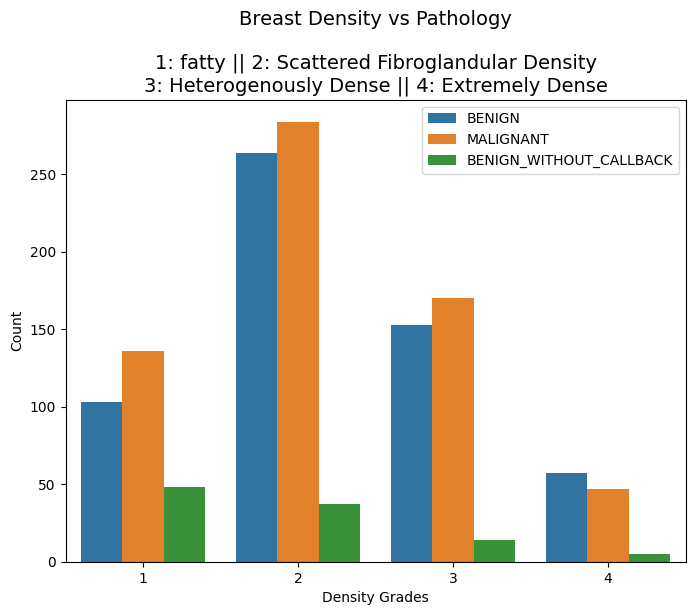

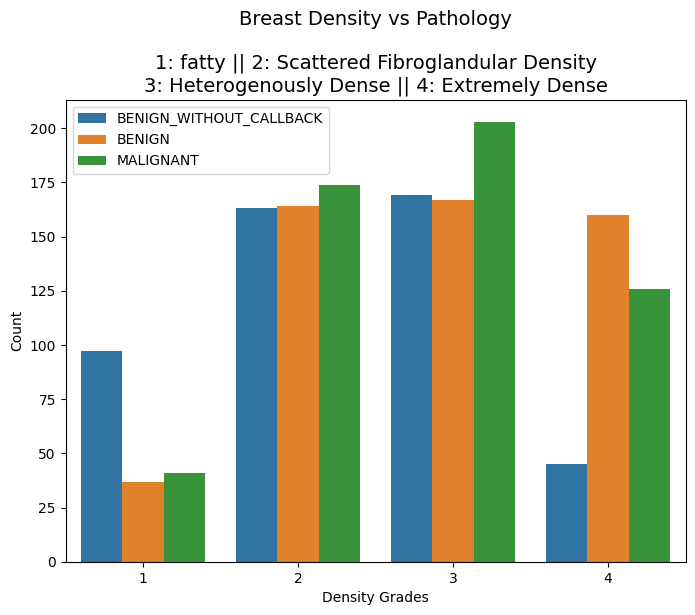

In [85]:
# breast density against pathology
plt.figure(figsize=(8,6))

sns.countplot(mass_train, x='breast_density', hue='pathology')
plt.title('Breast Density vs Pathology\n\n1: fatty || 2: Scattered Fibroglandular Density\n3: Heterogenously Dense || 4: Extremely Dense',
          fontsize=14)
plt.xlabel('Density Grades')
plt.ylabel('Count')
plt.legend()

plt.show()

# breast density against pathology
plt.figure(figsize=(8,6))

sns.countplot(calc_train, x='breast_density', hue='pathology')
plt.title('Breast Density vs Pathology\n\n1: fatty || 2: Scattered Fibroglandular Density\n3: Heterogenously Dense || 4: Extremely Dense',
          fontsize=14)
plt.xlabel('Density Grades')
plt.ylabel('Count')
plt.legend()

plt.show()

In [86]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

def display_images(dataset, column, number):
    """Display images with pathology label and image path."""
    fig, axes = plt.subplots(1, number, figsize=(20, 8))  # Widened for space

    for index, (i, row) in enumerate(dataset.head(number).iterrows()):
        image_path = row[column]

        # Check if image_path is valid (not None) and exists
        if image_path is None or not os.path.exists(image_path):
            continue

        image = cv2.imread(image_path)

        if image is None:
            continue

        # Convert BGR to RGB if needed
        if len(image.shape) == 3 and image.shape[2] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax = axes[index]
        ax.imshow(image, cmap='gray' if len(image.shape) == 2 else None)

        # Set title as pathology + image file name
        file_name = os.path.basename(image_path)
        ax.set_title(f"{row['pathology']}\n{file_name}", fontsize=10)  # New addition

        ax.axis('off')

        print(f"Image {index+1}: {image_path} - Shape: {np.array(image).shape}")

    plt.tight_layout()
    plt.show()


Full Mammograms:

Image 1: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515/1-211.jpg - Shape: (4808, 3024, 3)
Image 2: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.359308329312397897125630708681441180834/1-207.jpg - Shape: (4800, 2656, 3)
Image 3: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.89180046211022531834352631483669346540/1-250.jpg - Shape: (5491, 2986, 3)
Image 4: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.295360926313492745441868049270168300162/1-067.jpg - Shape: (5491, 3046, 3)
Image 5: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.410524754913057908920631336070876889890/1-056.jpg - Shape: (5491, 2911, 3)


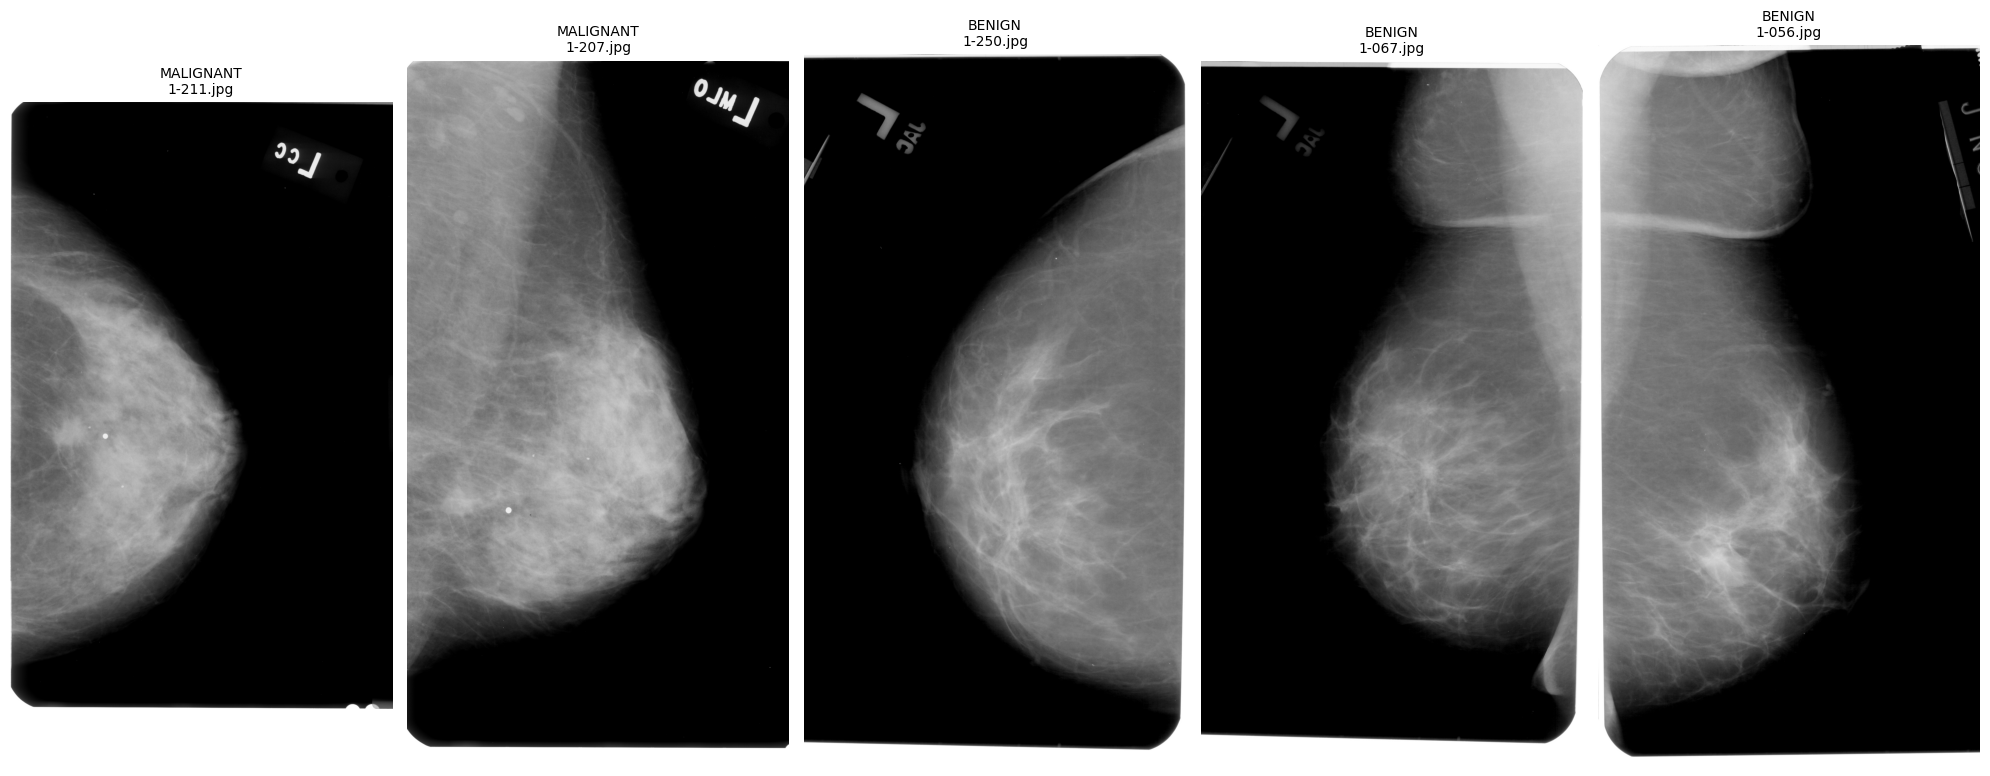

Cropped Mammograms:

Image 1: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650/2-249.jpg - Shape: (515, 431, 3)
Image 2: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.227955274711225756835838775062793186053/1-289.jpg - Shape: (292, 256, 3)
Image 3: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.429120414011832984817094399141838850375/2-295.jpg - Shape: (466, 423, 3)
Image 4: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.115134232113001553100559896703407510515/2-244.jpg - Shape: (427, 422, 3)
Image 5: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.12857366312625701203276284233604184846/1-182.jpg - Shape: (399, 465, 3)


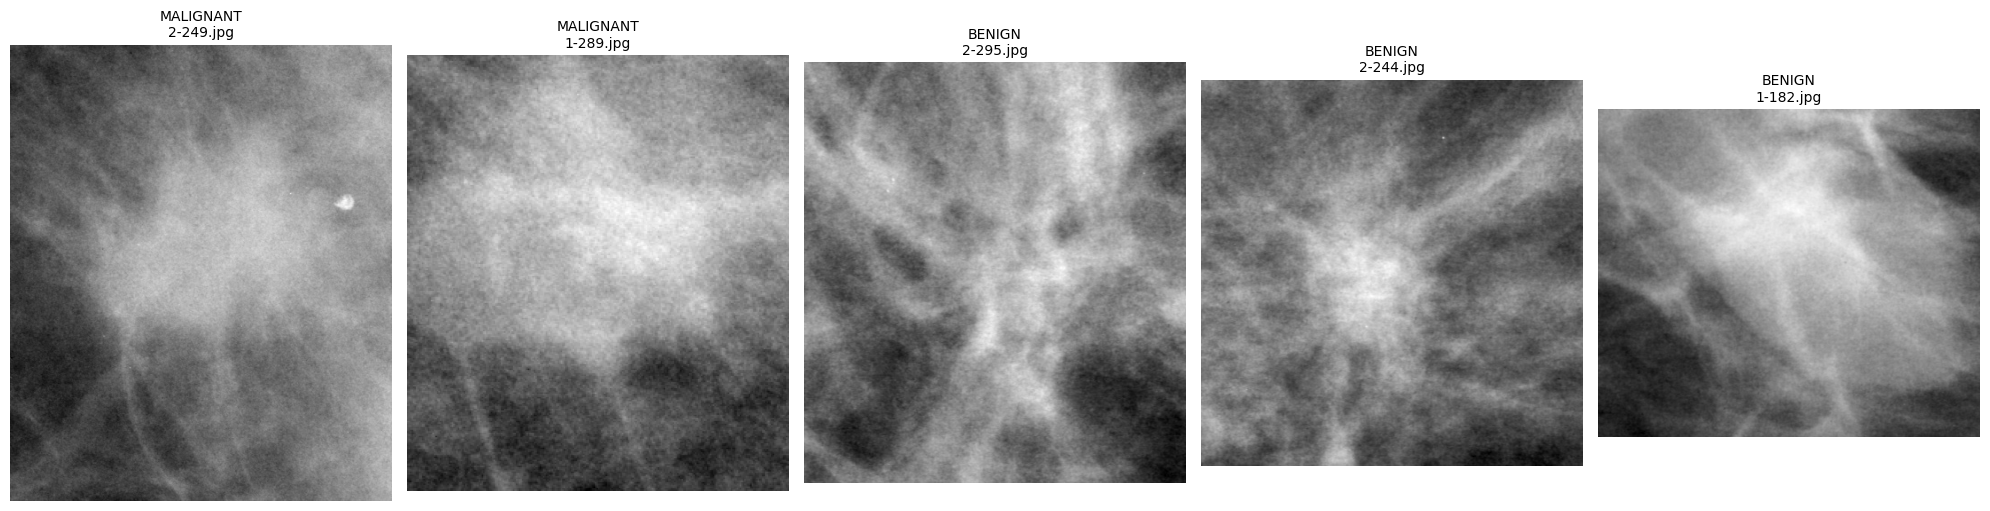

ROI_mask:

Image 1: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650/1-250.jpg - Shape: (4808, 3024, 3)
Image 2: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.227955274711225756835838775062793186053/2-288.jpg - Shape: (4800, 2656, 3)
Image 3: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.429120414011832984817094399141838850375/1-296.jpg - Shape: (5491, 2986, 3)
Image 4: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.115134232113001553100559896703407510515/1-245.jpg - Shape: (5491, 3046, 3)
Image 5: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.12857366312625701203276284233604184846/2-183.jpg - Shape: (5491, 2911, 3)


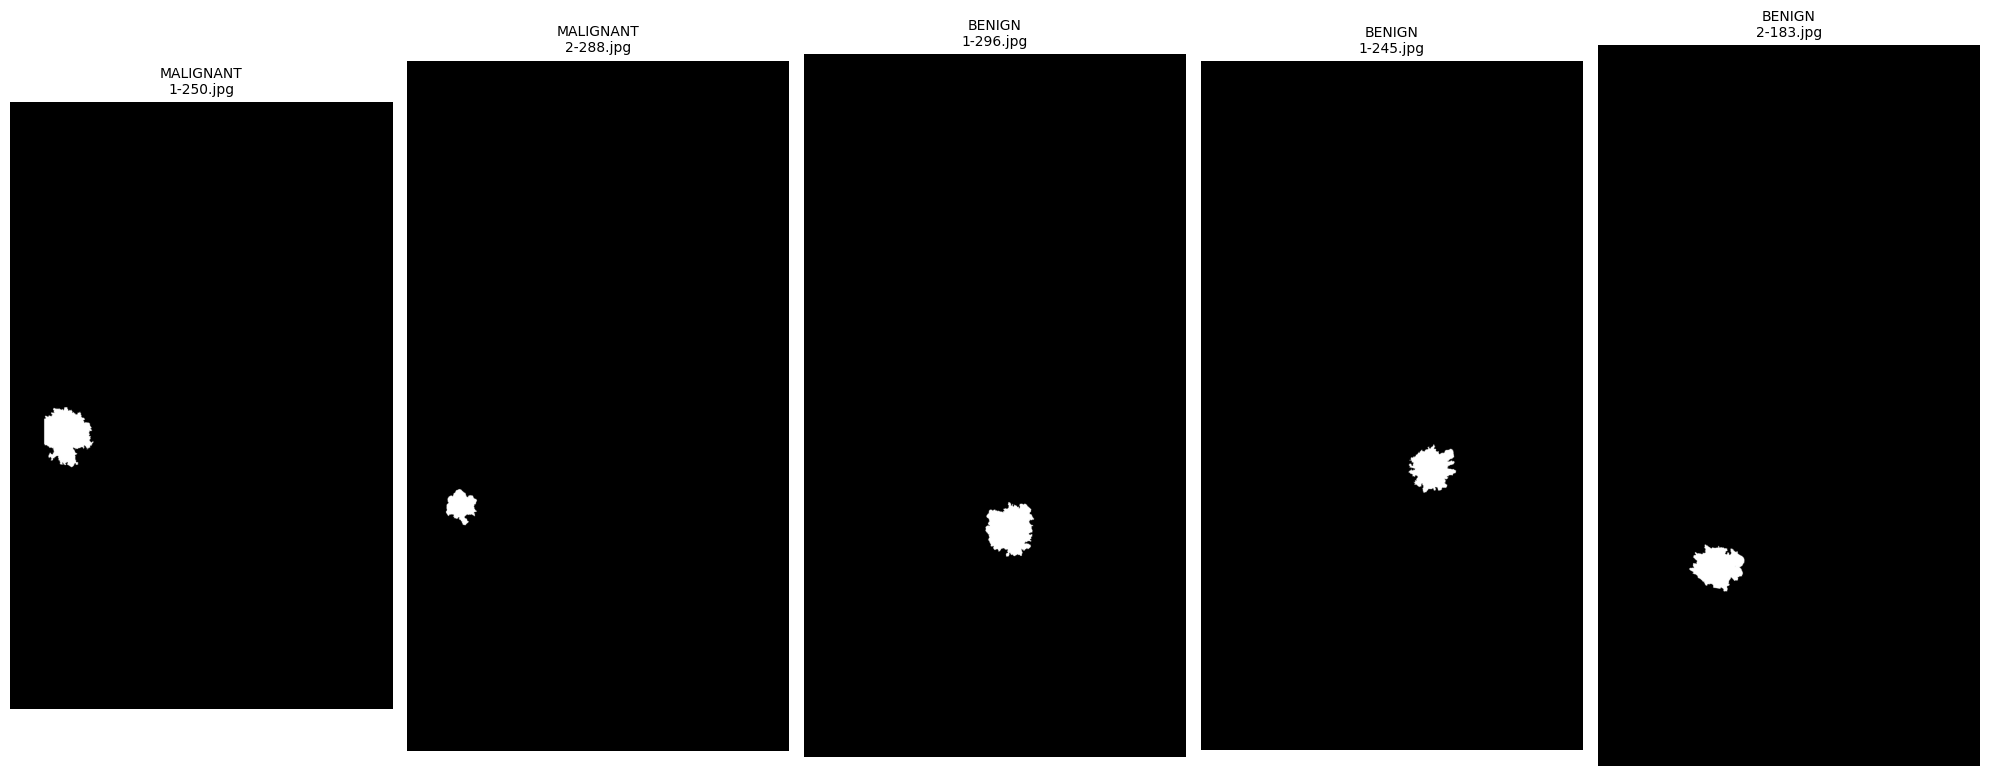

In [87]:
print('Full Mammograms:\n')
display_images(mass_train, 'image_file_path', 5)
print('Cropped Mammograms:\n')
display_images(mass_train, 'cropped_image_file_path', 5)
print('ROI_mask:\n')
display_images(mass_train, 'ROI_mask_file_path', 5)

Full Mammograms:

Image 1: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.245063149211255120613007755642780114172/1-271.jpg - Shape: (4006, 1846, 3)
Image 2: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.85952214611170506017891429690540035518/1-100.jpg - Shape: (5491, 2011, 3)
Image 3: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.22131189612893294827907969600765582967/1-101.jpg - Shape: (5904, 3200, 3)
Image 4: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.239949064412092068706566726490415129934/1-102.jpg - Shape: (5952, 3352, 3)
Image 5: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.215081818713600536113960661873725083371/1-103.jpg - Shape: (5116, 2641, 3)


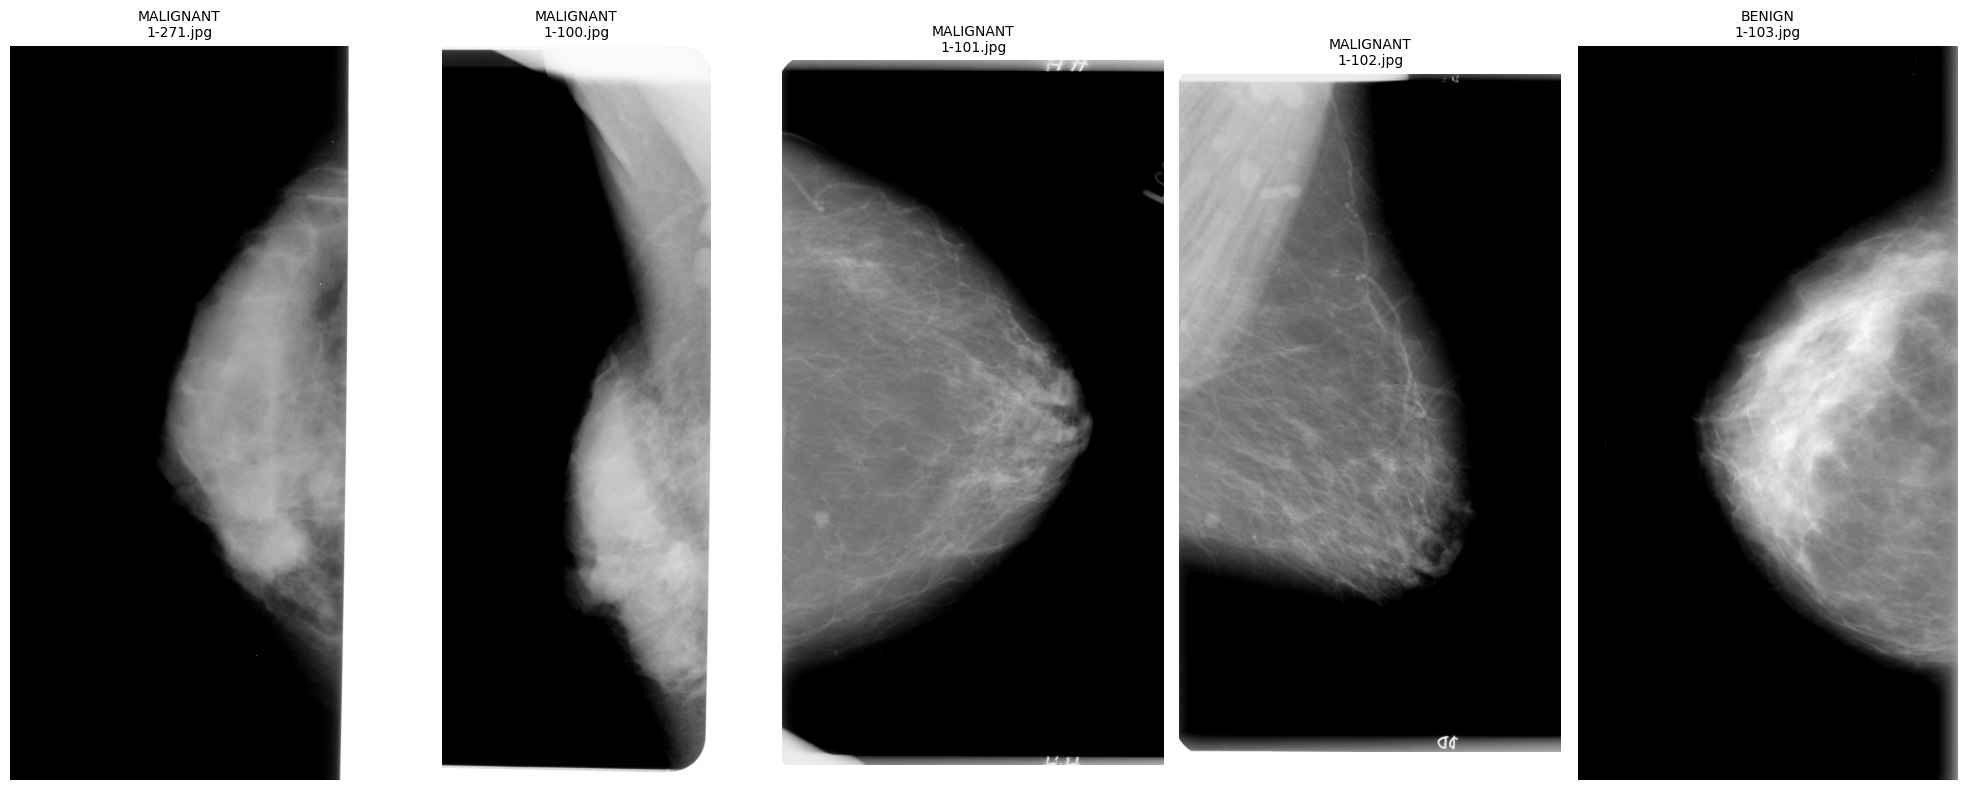

Cropped Mammograms:

Image 1: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.30820586311062570442302321942433426184/2-272.jpg - Shape: (384, 385, 3)
Image 2: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.381440141511137044327302306604206077287/2-273.jpg - Shape: (369, 328, 3)
Image 3: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.212143028513012144941507232513982203672/1-274.jpg - Shape: (214, 195, 3)
Image 4: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.15403043813402510742192372832381918984/1-275.jpg - Shape: (220, 225, 3)
Image 5: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.199593071810497070809647901570077988031/1-276.jpg - Shape: (405, 376, 3)


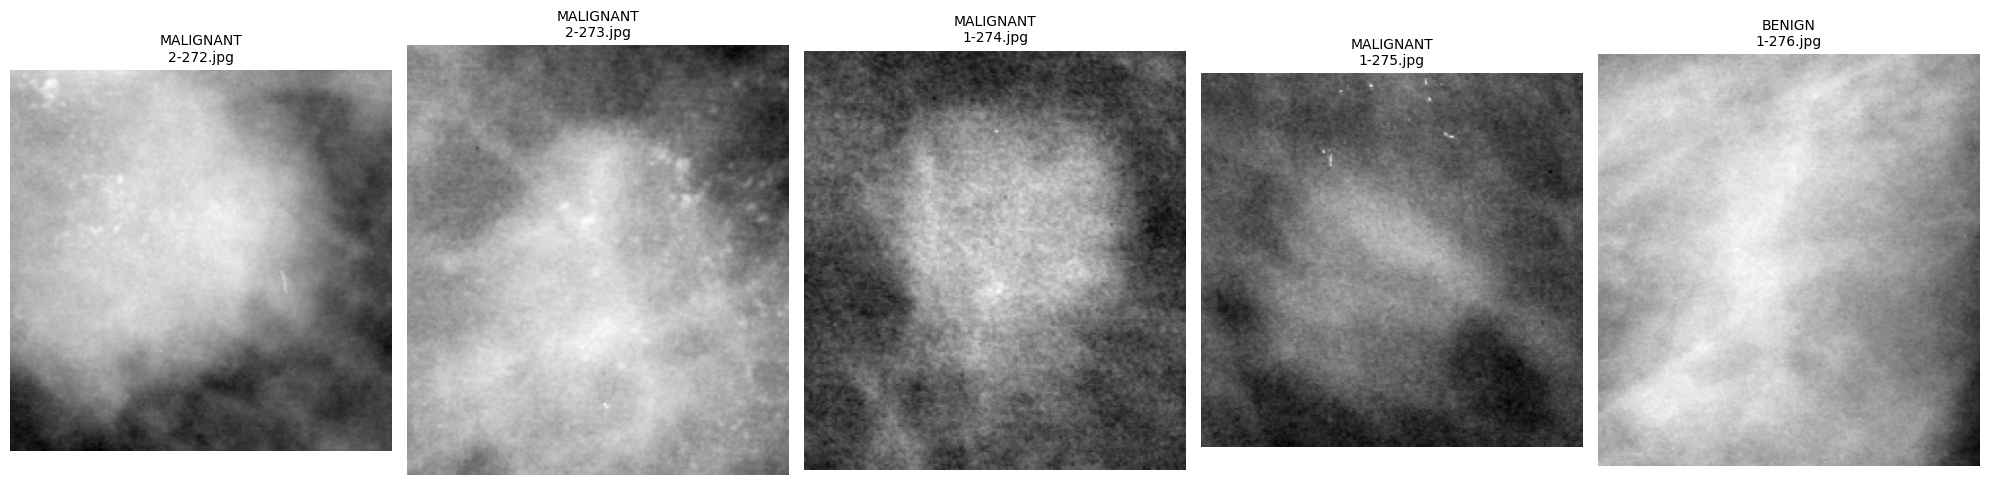

ROI_mask:

Image 1: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.30820586311062570442302321942433426184/1-083.jpg - Shape: (4006, 1846, 3)
Image 2: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.381440141511137044327302306604206077287/1-084.jpg - Shape: (5491, 2011, 3)
Image 3: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.212143028513012144941507232513982203672/2-085.jpg - Shape: (5904, 3200, 3)
Image 4: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.15403043813402510742192372832381918984/2-086.jpg - Shape: (5952, 3352, 3)
Image 5: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.199593071810497070809647901570077988031/2-087.jpg - Shape: (5116, 2641, 3)


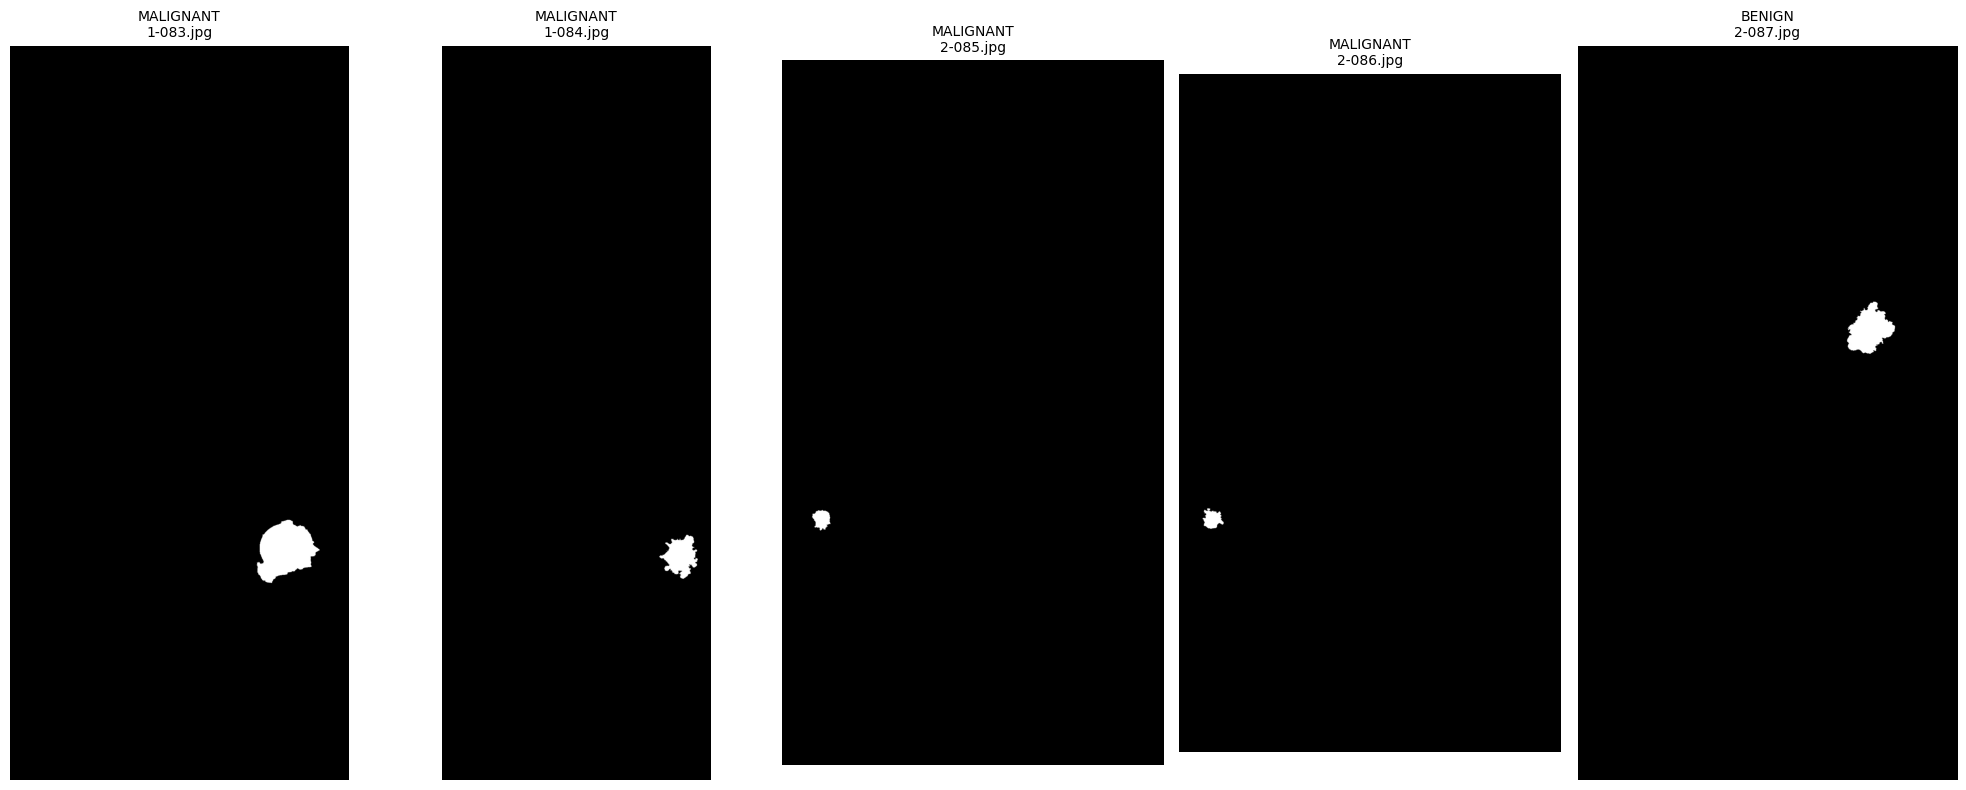

In [88]:
print('Full Mammograms:\n')
display_images(mass_test, 'image_file_path', 5)
print('Cropped Mammograms:\n')
display_images(mass_test, 'cropped_image_file_path', 5)
print('ROI_mask:\n')
display_images(mass_test, 'ROI_mask_file_path', 5)

Full Mammograms:

Image 1: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.47414316010368386519740343172775938548/1-188.jpg - Shape: (5056, 2761, 3)
Image 2: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.250596608311207922527805669693579696727/1-189.jpg - Shape: (5386, 2836, 3)
Image 3: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.228699627313487111012474405462022068297/1-190.jpg - Shape: (5356, 2986, 3)
Image 4: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.104743410411133110629448544090466900446/1-191.jpg - Shape: (5491, 3166, 3)
Image 5: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.406725628213826290127343763811145520834/1-192.jpg - Shape: (4568, 3064, 3)


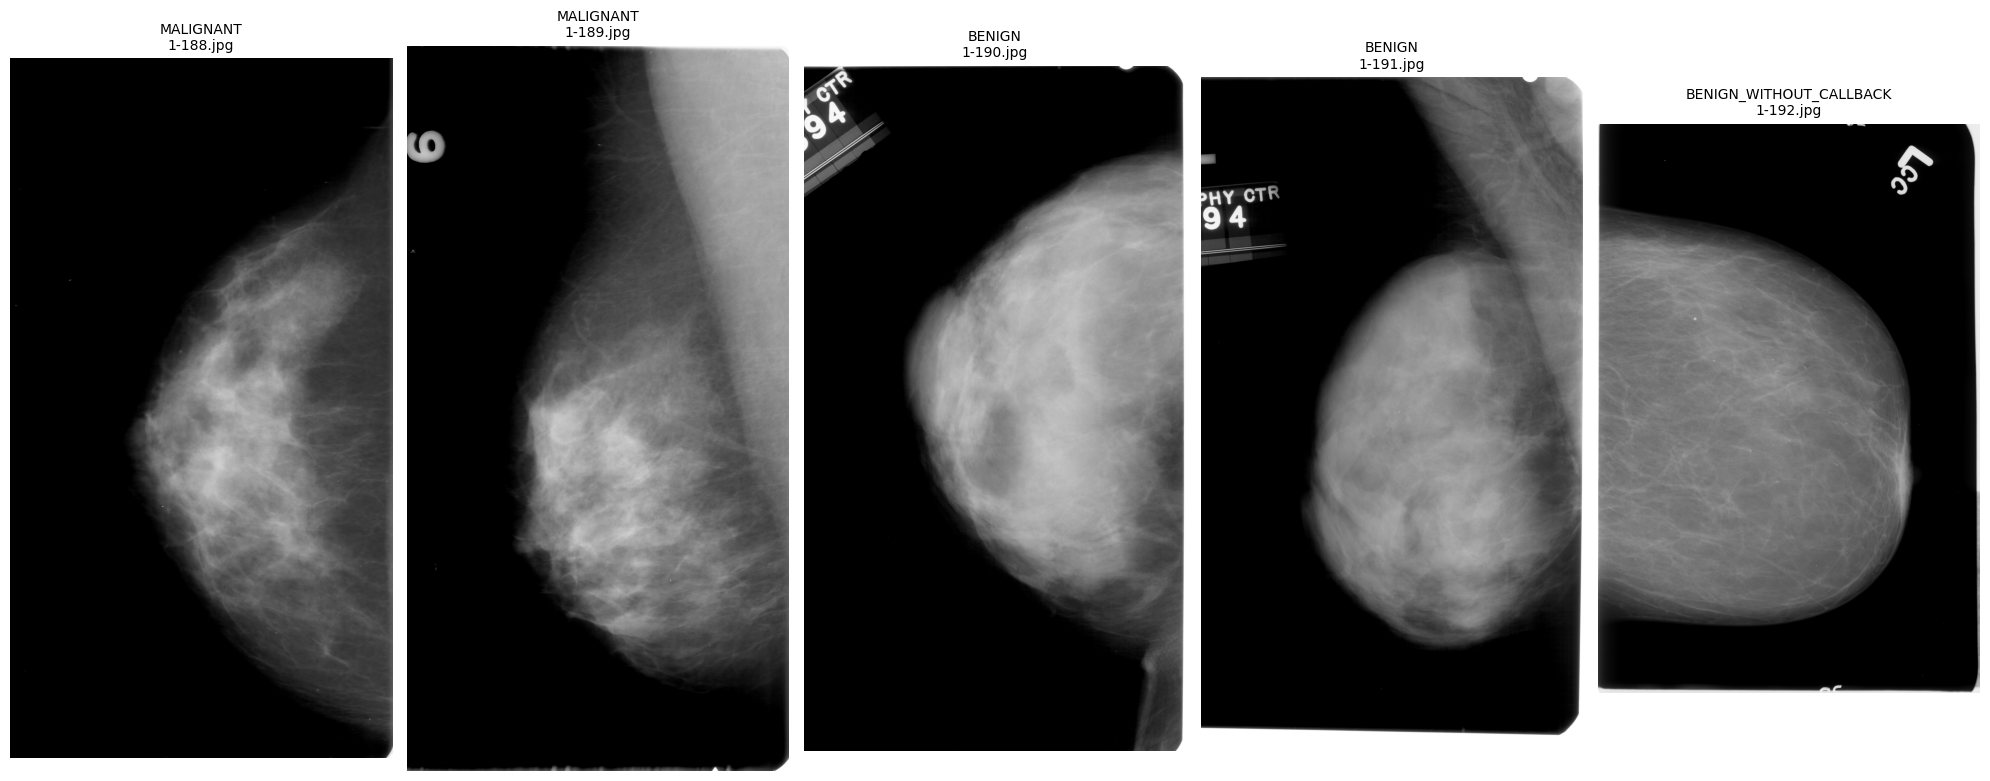

Cropped Mammograms:

Image 1: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.393344010211719049419601138200355094682/2-191.jpg - Shape: (589, 677, 3)
Image 2: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.296281207812130400303493285473798422894/1-192.jpg - Shape: (549, 681, 3)
Image 3: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.314135871111943890422150247820137952041/1-193.jpg - Shape: (681, 577, 3)
Image 4: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.91458279612485515203413781822560852485/1-194.jpg - Shape: (689, 761, 3)
Image 5: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.281397494612871934937455783843630775495/1-195.jpg - Shape: (161, 177, 3)


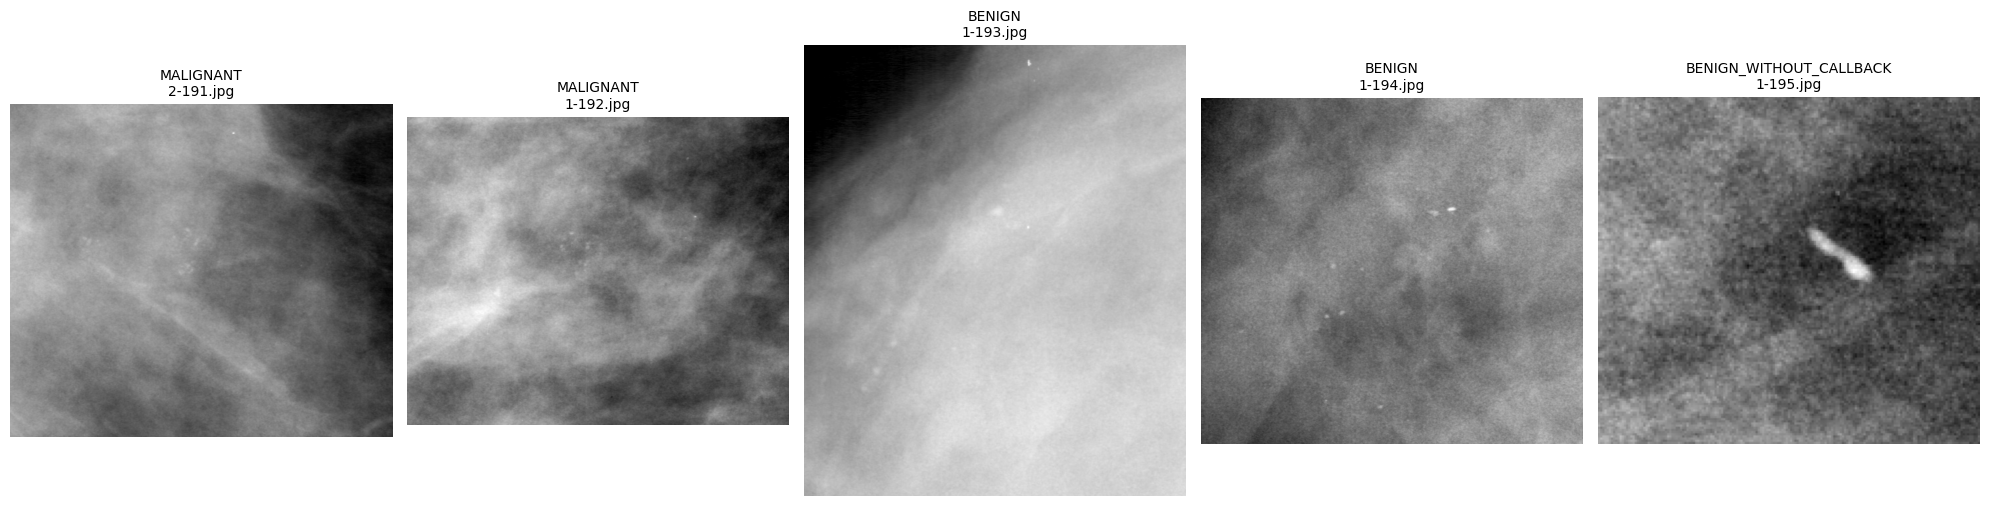

ROI_mask:

Image 1: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.393344010211719049419601138200355094682/1-107.jpg - Shape: (5056, 2761, 3)
Image 2: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.296281207812130400303493285473798422894/2-108.jpg - Shape: (5386, 2836, 3)
Image 3: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.314135871111943890422150247820137952041/2-109.jpg - Shape: (5356, 2986, 3)
Image 4: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.91458279612485515203413781822560852485/2-110.jpg - Shape: (5491, 3166, 3)
Image 5: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.281397494612871934937455783843630775495/2-111.jpg - Shape: (4568, 3064, 3)


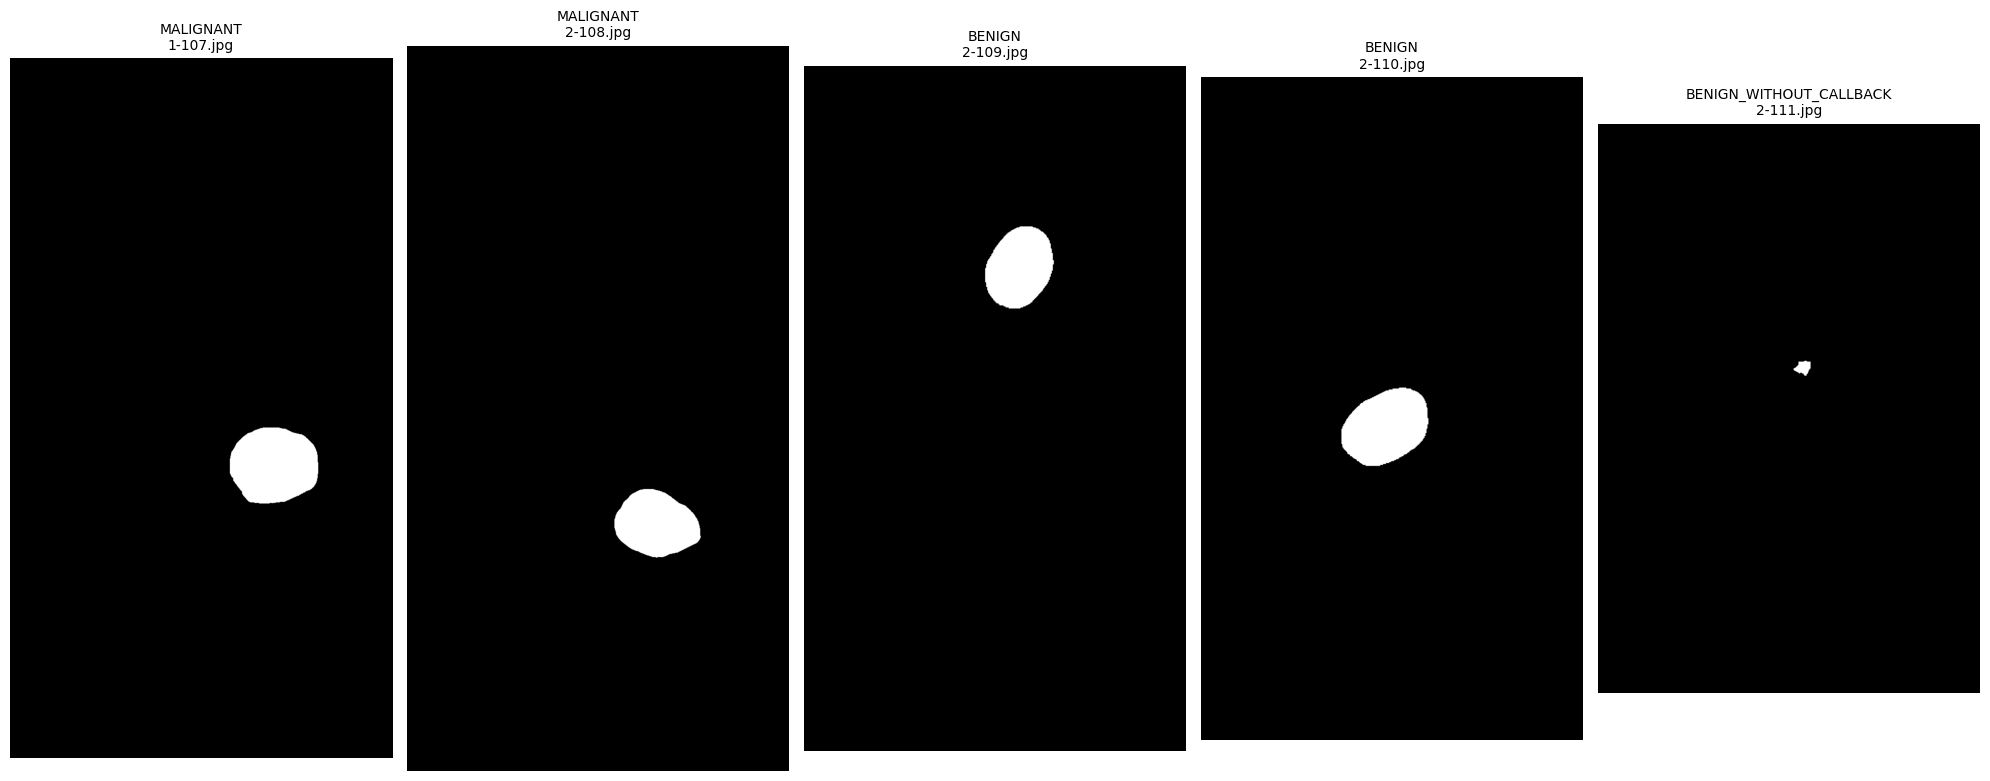

In [89]:
print('Full Mammograms:\n')
display_images(calc_train, 'image_file_path', 5)
print('Cropped Mammograms:\n')
display_images(calc_train, 'cropped_image_file_path', 5)
print('ROI_mask:\n')
display_images(calc_train, 'ROI_mask_file_path', 5)

Full Mammograms:



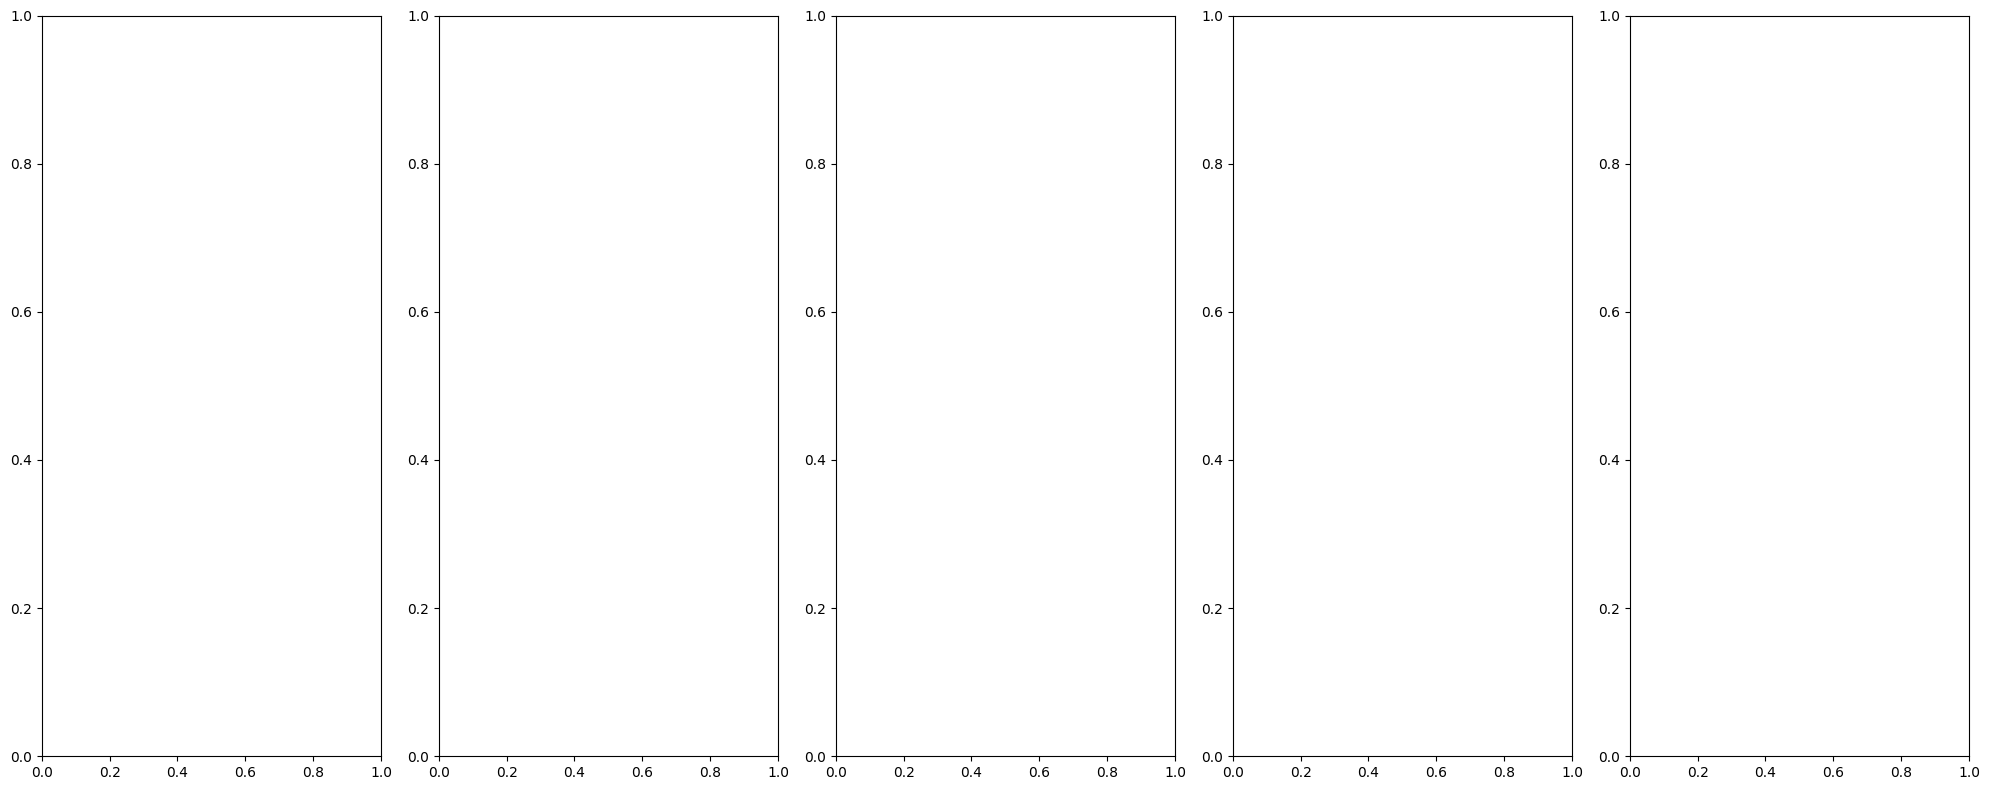

Cropped Mammograms:

Image 1: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.419081637812053404913157930753972718515/1-245.jpg - Shape: (249, 265, 3)
Image 2: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.188613955710170417803011787532523988680/1-246.jpg - Shape: (265, 249, 3)
Image 3: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.244876997513875090239564803900035037851/1-248.jpg - Shape: (409, 660, 3)
Image 4: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.360550081712464813321995483083632007570/1-247.jpg - Shape: (257, 724, 3)
Image 5: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.126295284812046209819441424913058621714/1-249.jpg - Shape: (809, 833, 3)


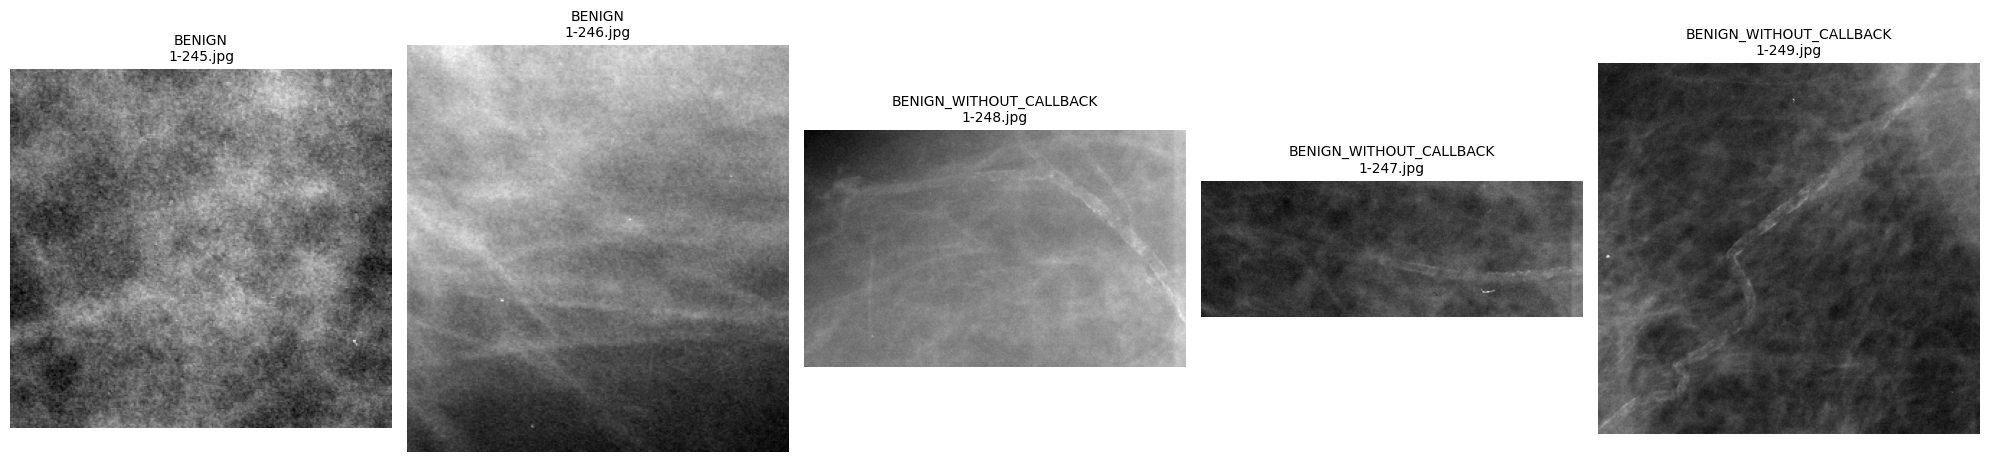

ROI_mask:



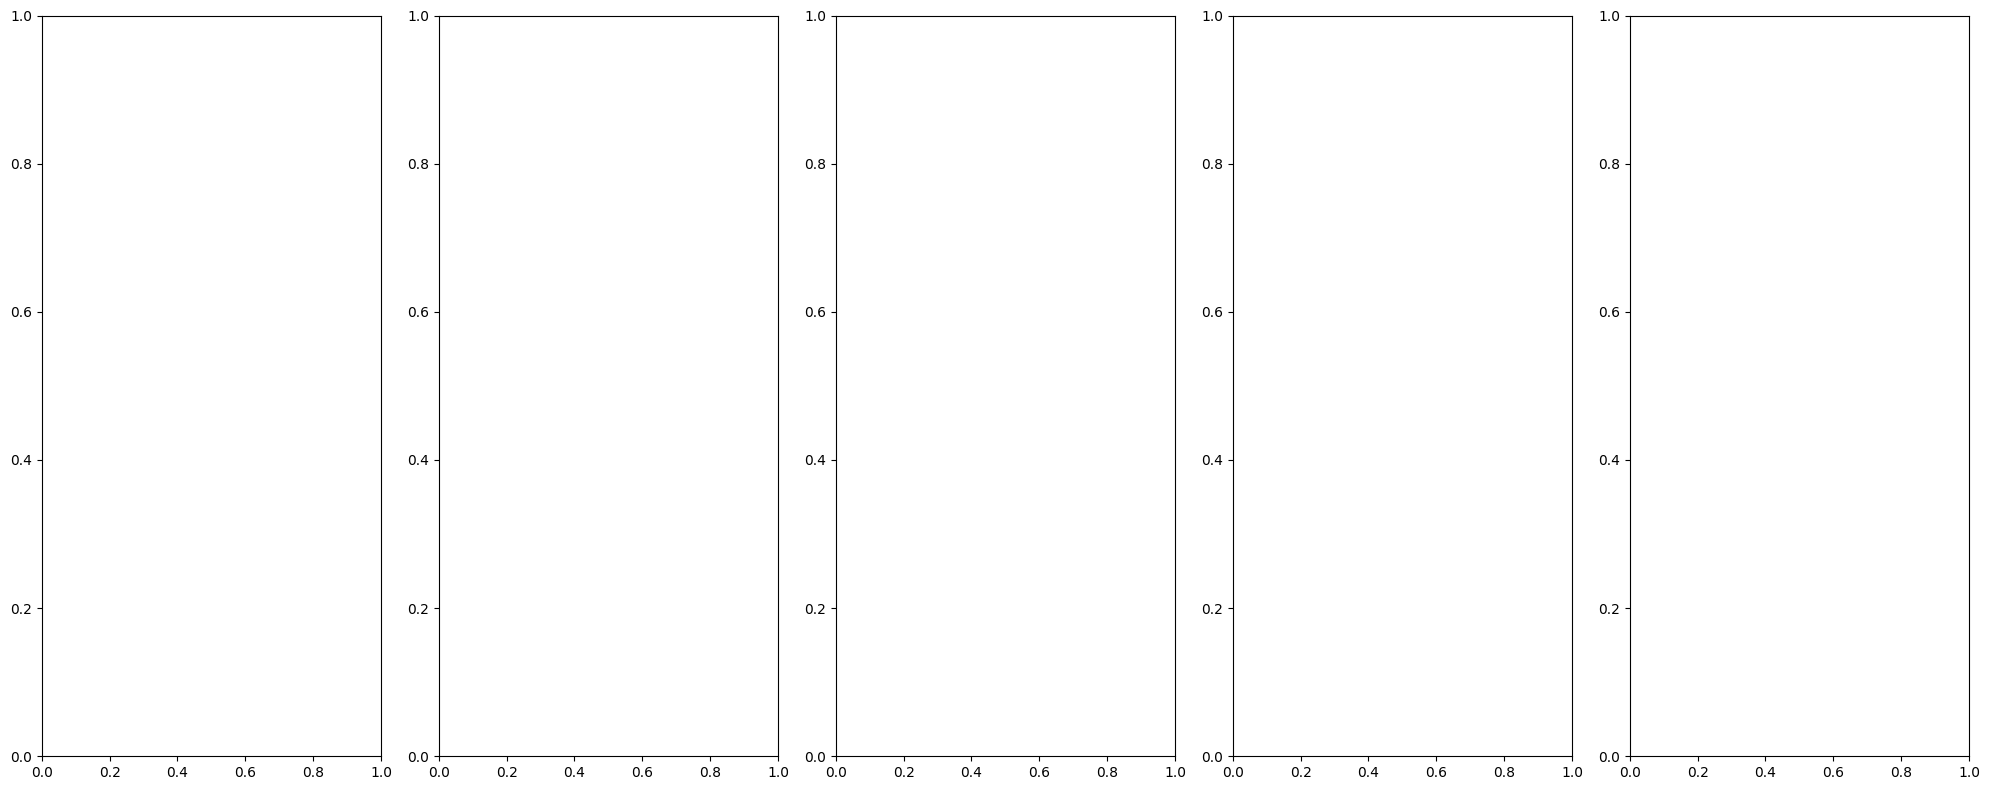

In [90]:
print('Full Mammograms:\n')
display_images(calc_test, 'image_file_path', 5)
print('Cropped Mammograms:\n')
display_images(calc_test, 'cropped_image_file_path', 5)
print('ROI_mask:\n')
display_images(calc_test, 'ROI_mask_file_path', 5)

In [91]:
dataset = pd.concat([mass_train, mass_test], axis=0)
len(dataset)
dataset.head()

patient_id  breast_density left_or_right_breast image_view  abnormality_id  \
0    P_00001               3                 LEFT         CC               1   
1    P_00001               3                 LEFT        MLO               1   
2    P_00004               3                 LEFT         CC               1   
3    P_00004               3                 LEFT        MLO               1   
4    P_00004               3                RIGHT        MLO               1   

  abnormality_type                          mass_shape   mass_margins  \
0             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
1             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
2             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
3             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
4             mass                                OVAL  CIRCUMSCRIBED   

   assessment  pathology  subtlety  \
0           4  MALIGNANT         4   
1           4  MALIGNANT         4   
2           4     BENIGN         3   
3           4     BENIGN         3   
4           4     BENIGN         5   

                                                                                                                       image_file_path  \
0  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515/1-211.jpg   
1  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.359308329312397897125630708681441180834/1-207.jpg   
2   /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.89180046211022531834352631483669346540/1-250.jpg   
3  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.295360926313492745441868049270168300162/1-067.jpg   
4  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.410524754913057908920631336070876889890/1-056.jpg   

                                                                                                               cropped_image_file_path  \
0  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650/2-249.jpg   
1  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.227955274711225756835838775062793186053/1-289.jpg   
2  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.429120414011832984817094399141838850375/2-295.jpg   
3  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.115134232113001553100559896703407510515/2-244.jpg   
4   /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.12857366312625701203276284233604184846/1-182.jpg   

                                                                                                                    ROI_mask_file_path  
0  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650/1-250.jpg  
1  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.227955274711225756835838775062793186053/2-288.jpg  
2  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.429120414011832984817094399141838850375/1-296.jpg  
3  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.115134232113001553100559896703407510515/1-245.jpg  
4   /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.12857366312625701203276284233604184846/2-183.jpg

In [92]:
dataset_classify = pd.concat([calc_train, calc_test], axis=0)
len(dataset_classify)
dataset_classify.head()

patient_id  breast_density left_or_right_breast image_view  abnormality_id  \
0    P_00005               3                RIGHT         CC               1   
1    P_00005               3                RIGHT        MLO               1   
2    P_00007               4                 LEFT         CC               1   
3    P_00007               4                 LEFT        MLO               1   
4    P_00008               1                 LEFT         CC               1   

  abnormality_type    calc_type calc_distribution  assessment  \
0    calcification    AMORPHOUS         CLUSTERED           3   
1    calcification    AMORPHOUS         CLUSTERED           3   
2    calcification  PLEOMORPHIC            LINEAR           4   
3    calcification  PLEOMORPHIC            LINEAR           4   
4    calcification          NaN          REGIONAL           2   

                 pathology  subtlety  \
0                MALIGNANT         3   
1                MALIGNANT         3   
2                   BENIGN         4   
3                   BENIGN         4   
4  BENIGN_WITHOUT_CALLBACK         3   

                                                                                                                       image_file_path  \
0   /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.47414316010368386519740343172775938548/1-188.jpg   
1  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.250596608311207922527805669693579696727/1-189.jpg   
2  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.228699627313487111012474405462022068297/1-190.jpg   
3  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.104743410411133110629448544090466900446/1-191.jpg   
4  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.406725628213826290127343763811145520834/1-192.jpg   

                                                                                                               cropped_image_file_path  \
0  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.393344010211719049419601138200355094682/2-191.jpg   
1  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.296281207812130400303493285473798422894/1-192.jpg   
2  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.314135871111943890422150247820137952041/1-193.jpg   
3   /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.91458279612485515203413781822560852485/1-194.jpg   
4  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.281397494612871934937455783843630775495/1-195.jpg   

                                                                                                                    ROI_mask_file_path  
0  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.393344010211719049419601138200355094682/1-107.jpg  
1  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.296281207812130400303493285473798422894/2-108.jpg  
2  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.314135871111943890422150247820137952041/2-109.jpg  
3   /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.91458279612485515203413781822560852485/2-110.jpg  
4  /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.281397494612871934937455783843630775495/2-111.jpg

In [93]:
class_mapper = {'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0}

## Data Preprocessing


In [94]:
target_size = (224, 224, 3)

dataset['labels'] = dataset['pathology'].replace(class_mapper).infer_objects(copy=False)

images = np.array(dataset[dataset["image_file_path"].notna()]["image_file_path"].tolist())
labels = np.array(dataset[dataset["image_file_path"].notna()]["labels"].tolist())
print("Length of full images:")
len(images)

labels_series = pd.Series(labels)
label_counts = labels_series.value_counts()

# Assuming 0 = benign and 1 = malignant
benign_count = label_counts.get(0, 0)
malignant_count = label_counts.get(1, 0)

print(f"Benign images: {benign_count}")
print(f"Malignant images: {malignant_count}")

num_classes = len(dataset['labels'].unique())
print(f'Number of classes: {num_classes}')

class_names = ['Benign', 'Malignant']
# Distribution of labels
label_counts = dataset['labels'].value_counts()
print(label_counts)



Length of full images:
Benign images: 912
Malignant images: 784
Number of classes: 2
labels
0    912
1    784
Name: count, dtype: int64


<ipython-input-94-f5ae5ae7ba94>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['labels'] = dataset['pathology'].replace(class_mapper).infer_objects(copy=False)


## For Classification Task:

In [95]:
target_size = (224, 224, 3)

dataset_classify['labels'] = dataset_classify['pathology'].replace(class_mapper).infer_objects(copy=False)

images = np.array(dataset_classify[dataset_classify["image_file_path"].notna()]["image_file_path"].tolist())
labels = np.array(dataset_classify[dataset_classify["image_file_path"].notna()]["labels"].tolist())
print("Length of full images:")
len(images)

labels_series = pd.Series(labels)
label_counts = labels_series.value_counts()

# Assuming 0 = benign and 1 = malignant
benign_count = label_counts.get(0, 0)
malignant_count = label_counts.get(1, 0)

print(f"Benign images: {benign_count}")
print(f"Malignant images: {malignant_count}")

num_classes = len(dataset_classify['labels'].unique())
print(f'Number of classes: {num_classes}')

class_names = ['Benign', 'Malignant']
# Distribution of labels
label_counts = dataset_classify['labels'].value_counts()
print(label_counts)



Length of full images:
Benign images: 1019
Malignant images: 571
Number of classes: 2
labels
0    1199
1     673
Name: count, dtype: int64


<ipython-input-95-d6a1f7272b08>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset_classify['labels'] = dataset_classify['pathology'].replace(class_mapper).infer_objects(copy=False)


In [96]:
import os
import cv2
import uuid
import shutil
import random
import numpy as np
import tensorflow as tf
from PIL import Image

# ========== 🔧 AUGMENTATION FUNCTIONS ==========

def apply_clahe_to_rgb(img_np):
    lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    return cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

def rotate_tensor_image(image, angle_degrees):
    # Convert angle to radians
    angle_rad = angle_degrees * np.pi / 180.0
    return tfa_rotate_fallback(image, angle_rad)

def tfa_rotate_fallback(image, angle_rad):
    # Build rotation matrix for affine transform
    h, w = tf.shape(image)[0], tf.shape(image)[1]
    cx, cy = tf.cast(w // 2, tf.float32), tf.cast(h // 2, tf.float32)

    cos_a = tf.math.cos(angle_rad)
    sin_a = tf.math.sin(angle_rad)

    rotation_matrix = tf.convert_to_tensor([
        [cos_a, -sin_a, (1 - cos_a) * cx + sin_a * cy],
        [sin_a,  cos_a, (1 - cos_a) * cy - sin_a * cx],
        [0, 0, 1]
    ])

    flat_matrix = tf.reshape(rotation_matrix, [-1])[:8]
    return tf.raw_ops.ImageProjectiveTransformV3(
        images=tf.expand_dims(image, 0),
        transforms=[flat_matrix],
        output_shape=[h, w],
        interpolation="BILINEAR",
        fill_value=0.0
    )[0]

def augment_image(image):
    # Convert to uint8 for OpenCV ops
    image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
    img_np = image.numpy()

    # Apply CLAHE
    img_np = apply_clahe_to_rgb(img_np)
    image = tf.convert_to_tensor(img_np, dtype=tf.uint8)

    # Random rotation between -15 and 15 degrees
    angle = random.uniform(-15, 15)
    image = rotate_tensor_image(image, angle)

    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    # Brightness, contrast, saturation
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)

    # Gaussian noise
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=10.0)
    image = tf.cast(image, tf.float32) + noise
    image = tf.clip_by_value(image, 0.0, 255.0)
    return tf.cast(image, tf.uint8)

def resize_image(image_tensor):
    return tf.image.resize(image_tensor, [224, 224])

# ========== 📂 DATA COPYING & BALANCING ==========

def copy_images_with_unique_filenames(images, labels, source, destination, target_count=None):
    benign_images = 0
    malignant_images = 0
    skipped_images = []

    # Clean destination dirs
    for label in ['0', '1']:
        dir_path = os.path.join(destination, label)
        if os.path.exists(dir_path):
            shutil.rmtree(dir_path)
        os.makedirs(dir_path, exist_ok=True)

    benign_list, malignant_list = [], []

    for i, (image, label) in enumerate(zip(images, labels)):
        if os.path.exists(image):
            try:
                filename = os.path.basename(image)
                unique_filename = f"{uuid.uuid4().hex}_{filename}"

                with Image.open(image) as img:
                    img = img.convert('RGB')
                    img_tensor = tf.convert_to_tensor(np.array(img), dtype=tf.uint8)
                    resized = resize_image(img_tensor)
                    augmented = augment_image(resized)
                    final_img = tf.keras.preprocessing.image.array_to_img(augmented)

                    target_dir = os.path.join(destination, str(label))
                    dest_path = os.path.join(target_dir, unique_filename)
                    final_img.save(dest_path, 'JPEG')

                    if label == 0:
                        benign_images += 1
                        benign_list.append(unique_filename)
                    else:
                        malignant_images += 1
                        malignant_list.append(unique_filename)

            except Exception as e:
                print(f" Error copying image {image}: {e}")
                skipped_images.append(image)
        else:
            print(f"Image not found: {image}")
            skipped_images.append(image)

    # Balance classes
    if len(benign_list) < len(malignant_list):
        augment_and_save_images(benign_list, os.path.join(destination, '0'), len(malignant_list) - len(benign_list))
    elif len(malignant_list) < len(benign_list):
        augment_and_save_images(malignant_list, os.path.join(destination, '1'), len(benign_list) - len(malignant_list))

    augment_and_save_images(benign_list, os.path.join(destination, '0'), target_count)
    augment_and_save_images(malignant_list, os.path.join(destination, '1'), target_count)

    print(f"\nCopying complete.")
    print(f"Benign: {benign_images} | Malignant: {malignant_images} | Skipped: {len(skipped_images)}")
    if skipped_images:
        print("Skipped images:")
        for img in skipped_images:
            print(img)

def augment_and_save_images(images_list, destination_dir, num_augments):
    if not num_augments: return
    for i in range(num_augments):
        img_name = random.choice(images_list)
        abs_path = os.path.join(destination_dir, img_name)
        try:
            with Image.open(abs_path) as img:
                img = img.convert('RGB')
                img_tensor = tf.convert_to_tensor(np.array(img), dtype=tf.uint8)
                augmented = augment_image(img_tensor)
                img_aug = tf.keras.preprocessing.image.array_to_img(augmented)
                img_base = os.path.splitext(img_name)[0]
                img_aug.save(os.path.join(destination_dir, f"{img_base}_aug{i}.jpg"), 'JPEG')
        except Exception as e:
            print(f"Error augmenting image {abs_path}: {e}")

source_dir = "/root/.cache/kagglehub/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset/versions/1/jpeg"
destination_dir = "/root/.cache/kagglehub/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset/versions/1/classification"

target_count = (len(labels) * 3) - len(labels)

images = np.array(dataset_classify[dataset_classify["image_file_path"].notna()]["image_file_path"].tolist())
labels = np.array(dataset_classify[dataset_classify["image_file_path"].notna()]["labels"].tolist())
copy_images_with_unique_filenames(images, labels, source_dir, destination_dir, target_count)



Copying complete.
Benign: 1019 | Malignant: 571 | Skipped: 0


In [97]:
# Zip the classification dataset
import os

# Absolute path
classification_full_path = '/root/.cache/kagglehub/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset/versions/1/classification'

# Move to parent and zip
classification_parent_dir = os.path.dirname(classification_full_path)
classification_folder_name = os.path.basename(classification_full_path)

!cd "{classification_parent_dir}" && zip -r /content/classification.zip "{classification_folder_name}"


Streaming output truncated to the last 5000 lines.
  adding: classification/0/baae0dc194764604833d317c436aefa7_1-042_aug942.jpg (deflated 2%)
  adding: classification/0/51928ce99c7c4d0da838b6bfdbf08d82_1-195_aug950.jpg (deflated 1%)
  adding: classification/0/d6ad074635524a85b4f3e4e3a3050732_1-062_aug2432.jpg (deflated 1%)
  adding: classification/0/a994dbd1613c441588d21c1f0347b1dc_1-287.jpg (deflated 3%)
  adding: classification/0/79485fd9f2cf4fc28d17e33e928b951a_1-010_aug422.jpg (deflated 2%)
  adding: classification/0/dae6d47eb1e3426bb705a6c3537b6a69_1-006_aug2859.jpg (deflated 2%)
  adding: classification/0/e4315d681e7740f795b92c156a260ab1_1-006.jpg (deflated 3%)
  adding: classification/0/d77a01fe280a4866a44d73d11348c9f0_1-236.jpg (deflated 3%)
  adding: classification/0/d8f8d18477724b1eab86acef9b140a4b_1-159_aug2275.jpg (deflated 1%)
  adding: classification/0/57b90117f01a40a99b4cac37d4858dd6_1-118.jpg (deflated 3%)
  adding: classification/0/9848676e1beb471381d47dc7e9638244_1-00

## For Segmentation Task:


In [98]:
# import os
# import cv2
# import matplotlib.pyplot as plt
# from PIL import Image

# # ✅ Paths (same as you shared)
# full_mammo_dir = '/root/.cache/kagglehub/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset/versions/1/segmentation_images/original'
# full_mask_dir = '/root/.cache/kagglehub/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset/versions/1/segmentation_images/masked'

# # Choose ONE image manually
# # Example: first image
# filename = sorted(os.listdir(full_mammo_dir))[0]  # You can change index if needed

# mammo_path = os.path.join(full_mammo_dir, filename)
# mask_path = os.path.join(full_mask_dir, filename)

# print(f"Processing file: {filename}")

# # Load image and mask
# mammo = Image.open(mammo_path).convert('RGB')
# mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# # Threshold mask
# _, binary = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)

# # Find contours
# contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# if contours:
#     largest = max(contours, key=cv2.contourArea)
#     x, y, w, h = cv2.boundingRect(largest)

#     # ✅ Optional: add margin
#     margin = 20
#     x = max(x - margin, 0)
#     y = max(y - margin, 0)
#     w = min(w + 2*margin, binary.shape[1] - x)
#     h = min(h + 2*margin, binary.shape[0] - y)

#     # Crop
#     mammo_crop = mammo.crop((x, y, x + w, y + h))
#     mask_crop = mask[y:y+h, x:x+w]

#     # Resize
#     target_size = (512, 512)
#     mammo_crop = mammo_crop.resize(target_size)
#     mask_crop = cv2.resize(mask_crop, target_size, interpolation=cv2.INTER_NEAREST)

#     # Save (optional if you want to download)
#     mammo_crop.save('/content/cropped_mammo_test.png')
#     cv2.imwrite('/content/cropped_mask_test.png', mask_crop)

#     # Visualize
#     fig, axs = plt.subplots(2, 2, figsize=(12, 8))

#     axs[0,0].imshow(mammo)
#     axs[0,0].set_title('Original Mammogram')
#     axs[0,0].axis('off')

#     axs[0,1].imshow(mask, cmap='gray')
#     axs[0,1].set_title('Original ROI Mask')
#     axs[0,1].axis('off')

#     axs[1,0].imshow(mammo_crop)
#     axs[1,0].set_title('Cropped Mammogram')
#     axs[1,0].axis('off')

#     axs[1,1].imshow(mask_crop, cmap='gray')
#     axs[1,1].set_title('Cropped ROI Mask')
#     axs[1,1].axis('off')

#     plt.tight_layout()
#     plt.show()

# else:
#     print("No lesion found in this mask.")


In [99]:
import os
import shutil
from PIL import Image
from tqdm import tqdm

# Source columns
image_paths = dataset['image_file_path']
mask_paths = dataset['ROI_mask_file_path']

# Output folders
base_dir = '/root/.cache/kagglehub/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset/versions/1/segmentation_images'
original_dir = os.path.join(base_dir, 'original')
masked_dir = os.path.join(base_dir, 'masked')

os.makedirs(original_dir, exist_ok=True)
os.makedirs(masked_dir, exist_ok=True)

# Save paired image and mask
for i, (img_path, mask_path) in tqdm(enumerate(zip(image_paths, mask_paths)), total=len(dataset)):
    try:
        if not os.path.exists(img_path) or not os.path.exists(mask_path):
            continue

        # Load and convert
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Grayscale

        # Optional: resize to same size
        img = img.resize((512, 512))
        mask = mask.resize((512, 512))

        # Save using a consistent name
        filename = f"pair_{i:04d}.png"
        img.save(os.path.join(original_dir, filename))
        mask.save(os.path.join(masked_dir, filename))

    except Exception as e:
        print(f"Error at {i}: {e}")


100%|██████████| 1696/1696 [13:28<00:00,  2.10it/s]


In [100]:
import os
import cv2
from PIL import Image
from tqdm import tqdm

full_mammo_dir = '/root/.cache/kagglehub/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset/versions/1/segmentation_images/original'  # Full mammogram images
full_mask_dir = '/root/.cache/kagglehub/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset/versions/1/segmentation_images/masked'    # Full ROI masks



# Output directories for cropped images and cropped masks
cropped_base_dir = '/root/.cache/kagglehub/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset/versions/1/segmentation'
cropped_original_dir = os.path.join(cropped_base_dir, 'original')
cropped_masked_dir = os.path.join(cropped_base_dir, 'masked')

os.makedirs(cropped_original_dir, exist_ok=True)
os.makedirs(cropped_masked_dir, exist_ok=True)

# Target resize size
target_size = (512, 512)

# Process each full mammogram and ROI mask
full_mammo_files = sorted(os.listdir(full_mammo_dir))

for i, filename in tqdm(enumerate(full_mammo_files), total=len(full_mammo_files)):
    if not (filename.endswith('.png') or filename.endswith('.jpg')):
        continue

    mammo_path = os.path.join(full_mammo_dir, filename)
    mask_path = os.path.join(full_mask_dir, filename)  # Assuming matching filenames

    if not os.path.exists(mammo_path) or not os.path.exists(mask_path):
        continue

    # Load full mammogram and full mask
    mammo = Image.open(mammo_path).convert('RGB')
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if mask is None:
        continue

    # Threshold mask to binary
    _, binary = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)

    # Find all contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Find only the largest contour (tumor)
        largest = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest)

        # Optional: Add margin to bounding box
        margin = 20  # pixels
        x = max(x - margin, 0)
        y = max(y - margin, 0)
        w = min(w + 2 * margin, binary.shape[1] - x)
        h = min(h + 2 * margin, binary.shape[0] - y)

        # Crop full mammogram and mask
        mammo_crop = mammo.crop((x, y, x + w, y + h))
        mask_crop = mask[y:y+h, x:x+w]

        # Resize both to target size
        mammo_crop = mammo_crop.resize(target_size)
        mask_crop = cv2.resize(mask_crop, target_size, interpolation=cv2.INTER_NEAREST)

        # Save cropped image and mask
        cropped_img_save_path = os.path.join(cropped_original_dir, f"crop_{i:04d}.png")
        cropped_mask_save_path = os.path.join(cropped_masked_dir, f"crop_{i:04d}.png")

        mammo_crop.save(cropped_img_save_path)
        cv2.imwrite(cropped_mask_save_path, mask_crop)


# Zip the cropped segmentation dataset
cropped_full_path = '/root/.cache/kagglehub/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset/versions/1/segmentation'

# Move to parent and zip
cropped_parent_dir = os.path.dirname(cropped_full_path)
cropped_folder_name = os.path.basename(cropped_full_path)

!cd "{cropped_parent_dir}" && zip -r /content/segmentation.zip "{cropped_folder_name}"


100%|██████████| 1696/1696 [01:27<00:00, 19.30it/s]


  adding: segmentation/ (stored 0%)
  adding: segmentation/masked/ (stored 0%)
  adding: segmentation/masked/crop_1686.png (deflated 45%)
  adding: segmentation/masked/crop_1391.png (deflated 34%)
  adding: segmentation/masked/crop_0325.png (deflated 26%)
  adding: segmentation/masked/crop_1178.png (deflated 25%)
  adding: segmentation/masked/crop_0532.png (deflated 45%)
  adding: segmentation/masked/crop_0784.png (deflated 35%)
  adding: segmentation/masked/crop_0253.png (deflated 48%)
  adding: segmentation/masked/crop_0534.png (deflated 44%)
  adding: segmentation/masked/crop_0753.png (deflated 35%)
  adding: segmentation/masked/crop_1284.png (deflated 35%)
  adding: segmentation/masked/crop_1550.png (deflated 36%)
  adding: segmentation/masked/crop_0724.png (deflated 32%)
  adding: segmentation/masked/crop_0422.png (deflated 43%)
  adding: segmentation/masked/crop_1607.png (deflated 55%)
  adding: segmentation/masked/crop_0802.png (deflated 37%)
  adding: segmentation/masked/crop_0

## For Detection Task:


In [101]:
# import os
# import cv2
# import matplotlib.pyplot as plt
# from PIL import Image

# # ✅ Paths (your structure)
# full_mammo_dir = '/root/.cache/kagglehub/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset/versions/1/segmentation_images/original'
# full_mask_dir = '/root/.cache/kagglehub/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset/versions/1/segmentation_images/masked'

# # Select ONE image manually
# filename = sorted(os.listdir(full_mammo_dir))[20]  # You can change index if needed

# mammo_path = os.path.join(full_mammo_dir, filename)
# mask_path = os.path.join(full_mask_dir, filename)

# print(f"Processing file: {filename}")

# # Load full mammogram and full mask
# img = Image.open(mammo_path).convert('RGB')
# mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# if mask is None:
#     print("Mask not found or empty!")
# else:
#     # Original size
#     orig_width, orig_height = img.size

#     # Resize target
#     target_size = (512, 512)

#     # Resize image
#     img_resized = img.resize(target_size)

#     # Threshold mask
#     _, binary = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)

#     # Find contours
#     contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     if contours:
#         largest = max(contours, key=cv2.contourArea)
#         x, y, w, h = cv2.boundingRect(largest)

#         # Scale bounding box to resized image
#         x_scale = target_size[0] / orig_width
#         y_scale = target_size[1] / orig_height

#         x_min = x * x_scale
#         y_min = y * y_scale
#         width = w * x_scale
#         height = h * y_scale

#         # YOLO format
#         class_id = 0
#         x_center = (x_min + width / 2) / target_size[0]
#         y_center = (y_min + height / 2) / target_size[1]
#         width_norm = width / target_size[0]
#         height_norm = height / target_size[1]

#         # Print YOLO Label
#         print(f"YOLO label (class x_center y_center width height):")
#         print(f"{class_id} {x_center:.6f} {y_center:.6f} {width_norm:.6f} {height_norm:.6f}")

#         # ✅ Visualize All
#         img_for_plot = cv2.cvtColor(cv2.imread(mammo_path), cv2.COLOR_BGR2RGB)
#         img_for_plot = cv2.resize(img_for_plot, target_size)

#         # Draw bounding box on resized image
#         x1 = int(x_min)
#         y1 = int(y_min)
#         x2 = int(x_min + width)
#         y2 = int(y_min + height)
#         cv2.rectangle(img_for_plot, (x1, y1), (x2, y2), (255, 0, 0), 2)

#         # Full-size mask for visualization
#         plt.figure(figsize=(15,5))

#         plt.subplot(1, 3, 1)
#         plt.imshow(img, cmap='gray')
#         plt.title('Full Mammogram (Original Size)')
#         plt.axis('off')

#         plt.subplot(1, 3, 2)
#         plt.imshow(mask, cmap='gray')
#         plt.title('Full ROI Mask (Original Size)')
#         plt.axis('off')

#         plt.subplot(1, 3, 3)
#         plt.imshow(img_for_plot)
#         plt.title('Resized Mammogram with Bounding Box')
#         plt.axis('off')

#         plt.tight_layout()
#         plt.show()

#     else:
#         print("No lesion found in this mask.")


In [102]:
import os
import cv2
from PIL import Image
from tqdm import tqdm

# ✅ Source full images and full masks
full_mammo_dir = '/root/.cache/kagglehub/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset/versions/1/segmentation_images/original'
full_mask_dir = '/root/.cache/kagglehub/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset/versions/1/segmentation_images/masked'

# Output folders for detection dataset
detect_base_dir = '/root/.cache/kagglehub/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset/versions/1/detection'
detect_images_dir = os.path.join(detect_base_dir, 'images')
detect_labels_dir = os.path.join(detect_base_dir, 'labels')

os.makedirs(detect_images_dir, exist_ok=True)
os.makedirs(detect_labels_dir, exist_ok=True)

# Resize target size
target_size = (512, 512)

# Process all files
full_mammo_files = sorted(os.listdir(full_mammo_dir))

for i, filename in tqdm(enumerate(full_mammo_files), total=len(full_mammo_files)):
    if not (filename.endswith('.png') or filename.endswith('.jpg')):
        continue

    mammo_path = os.path.join(full_mammo_dir, filename)
    mask_path = os.path.join(full_mask_dir, filename)

    if not os.path.exists(mammo_path) or not os.path.exists(mask_path):
        continue

    # Load images
    img = Image.open(mammo_path).convert('RGB')
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if mask is None:
        continue

    # Original size
    orig_width, orig_height = img.size

    # Resize image
    img = img.resize(target_size)
    img.save(os.path.join(detect_images_dir, f"det_{i:04d}.png"))

    # Resize mask
    _, binary = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest)

        # Scale bbox for resized image
        x_scale = target_size[0] / orig_width
        y_scale = target_size[1] / orig_height

        x_min = x * x_scale
        y_min = y * y_scale
        width = w * x_scale
        height = h * y_scale

        # YOLO format (class_id x_center y_center width height normalized)
        class_id = 0
        x_center = (x_min + width / 2) / target_size[0]
        y_center = (y_min + height / 2) / target_size[1]
        width_norm = width / target_size[0]
        height_norm = height / target_size[1]

        # Save label file
        label_path = os.path.join(detect_labels_dir, f"det_{i:04d}.txt")
        with open(label_path, 'w') as f:
            f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width_norm:.6f} {height_norm:.6f}\n")


100%|██████████| 1696/1696 [01:32<00:00, 18.29it/s]


In [103]:
# Zip the detection dataset
detect_full_path = '/root/.cache/kagglehub/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset/versions/1/detection'

# Move to parent and zip
detect_parent_dir = os.path.dirname(detect_full_path)
detect_folder_name = os.path.basename(detect_full_path)

!cd "{detect_parent_dir}" && zip -r /content/detection.zip "{detect_folder_name}"


  adding: detection/ (stored 0%)
  adding: detection/labels/ (stored 0%)
  adding: detection/labels/det_0949.txt (deflated 8%)
  adding: detection/labels/det_0424.txt (deflated 8%)
  adding: detection/labels/det_0331.txt (deflated 5%)
  adding: detection/labels/det_1274.txt (deflated 13%)
  adding: detection/labels/det_1609.txt (deflated 5%)
  adding: detection/labels/det_0997.txt (deflated 8%)
  adding: detection/labels/det_1489.txt (deflated 8%)
  adding: detection/labels/det_0173.txt (deflated 16%)
  adding: detection/labels/det_1066.txt (deflated 11%)
  adding: detection/labels/det_1185.txt (deflated 8%)
  adding: detection/labels/det_0393.txt (deflated 8%)
  adding: detection/labels/det_1127.txt (deflated 8%)
  adding: detection/labels/det_0061.txt (deflated 5%)
  adding: detection/labels/det_1022.txt (deflated 8%)
  adding: detection/labels/det_1469.txt (deflated 5%)
  adding: detection/labels/det_0701.txt (deflated 8%)
  adding: detection/labels/det_0482.txt (deflated 8%)
  addi